In [1]:
import sys
import os
from pprint import pprint
sys.path.append(os.path.abspath("../../../"))
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
from IPython.display import Markdown
import ipywidgets as iw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import usure.common.logging as usurelogging
from usure.config import config
from usure.classification.infrastructure import (
     BasicSentenceCleaner 
    ,FileLabeledCommentsDao
    ,FileWordVectorsRep)
from usure.classification.core import CnnLab, ClassifierInput, LabReport, WordVectorsService
from usure.classification.infrastructure import FileModelDao
import usure.classification.ui.utils as ui

Using TensorFlow backend.


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = lines => false

<IPython.core.display.Javascript object>

In [4]:
pd.set_option('colheader_justify', 'left')
pd.set_option('display.max_colwidth', 200)

In [5]:
cleaner = BasicSentenceCleaner(config.assets)
comments_dao = FileLabeledCommentsDao(config.classification, cleaner)
wv_rep = FileWordVectorsRep(config.embeddings)
model_dao = FileModelDao(config.models)
comments = comments_dao.get("intertass-CR-train-tagged.xml")

In [6]:
def classification_lab_report(word_vector_no, input, lab):
    display(Markdown(f'## {word_vector_no}. Creating models with embeddings: {input.embeddings_name}'))
    lab_report = lab.train_by_stratifiedkfold(input, folds=10)
    return lab_report

def model_architecture_summary(lab_report):
    display(Markdown(f'### Mean Accuracies and losses'))
    display(lab_report.summary)
    display(Markdown(f'### Accuracies and losses by Stratified KFold (folds with balanced class distributions)'))
    model_reports_df = ui.model_reports_to_DataFrame(lab_report.model_reports)
    display(model_reports_df) 
    
def show_statistics_by_model(word_vector_no, word_vector_name, lab_report):
    """Shows statistics by models created by every folds"""
    display(Markdown(f'## {word_vector_no}. {word_vector_name}'))
    for fold_no, model_report in enumerate(lab_report.model_reports):
        display(Markdown(f'### Fold number: {fold_no+1}. Name: {model_report.name}'))
        ui.plot_learning_curves_if_epoches(model_report)
        display(Markdown(f'### Training'))
        print(model_report.training.classification_report)
        confu_mtx = model_report.training.confusion_matrix
        display(confu_mtx)
        display(Markdown(f'### Validation'))
        print(model_report.validation.classification_report)
        confu_mtx = model_report.validation.confusion_matrix
        display(confu_mtx)

# Convolutional Neural Network

## 1. Creating models with embeddings: CorpusFBCR2013.txt.usu.bw.kvs

### Mean Accuracies and losses

,train_acc_mean,train_acc_stdev,val_acc_mean,val_acc_stdev
0,0.985139,0.004088,0.472291,0.067524


### Accuracies and losses by Stratified KFold (folds with balanced class distributions)

,model name,train_acc,train_loss,val_acc,val_loss
0,12c9f5f4a0ee47b6be4357d22cfd8d4c,0.986072,0.130566,0.475610,1.320661
1,91ca901c8d9c4adf8b491abb49b5f6ff,0.983310,0.167731,0.580247,1.180438
2,0277f105d9be48aca8433059455bb064,0.981919,0.159883,0.395062,1.729649
3,648c77a3838442d188e2ae2590b9d116,0.986092,0.159506,0.493827,1.430024
4,2c4fdc87c88f4897bf91ab01ef8648a4,0.988889,0.151075,0.525000,1.267698
5,6ef0e17d480242909d72a3048059934f,0.986130,0.157651,0.518987,1.217667
6,39c69e79ca964cb89a739e1b55c2bf6f,0.976422,0.178747,0.392405,1.592476
7,bf27be664c0d4d159ea00040a0de755b,0.991678,0.144272,0.443038,1.516274
8,b6da1c7deac04bd2b7a0b479ee4f4d0a,0.986130,0.135480,0.379747,1.492358
9,9b9e76a9c7314ff3b8016e1333928d66,0.984743,0.134748,0.518987,1.230906


## 2. Creating models with embeddings: CorpusFBCR2013.txt.usu.sw.kvs

### Mean Accuracies and losses

,train_acc_mean,train_acc_stdev,val_acc_mean,val_acc_stdev
0,0.987499,0.00376,0.487542,0.036097


### Accuracies and losses by Stratified KFold (folds with balanced class distributions)

,model name,train_acc,train_loss,val_acc,val_loss
0,df884a4b4bd4451192cd17748c568c38,0.987465,0.152207,0.439024,1.530621
1,0c7c0b1f458b4f1ca2c05569525d63dc,0.988873,0.147071,0.456790,1.565656
2,7f086accfa1044f7b7a2f26c9656b991,0.984701,0.144638,0.518519,1.498183
3,6998b1fdd59a45bfbb6a54a65d3ab9e5,0.988873,0.154903,0.543210,1.123638
4,52ef9ff2f19a472aad1407c06740386d,0.983333,0.156547,0.487500,1.297871
5,107106be894d47e3867b2b08d78d7674,0.990291,0.121118,0.481013,1.502066
6,1eed4761d13d42829482264ce709b1f3,0.994452,0.116197,0.506329,1.306986
7,c1689b43cc7a4bc28a58d9a064095d76,0.983356,0.143452,0.430380,1.468951
8,531f785f42304d8fa2036d81885882f3,0.990291,0.137392,0.506329,1.361285
9,5ff0422e1e0a45abb0276d7519a065a9,0.983356,0.153528,0.506329,1.159680


## 3. Creating models with embeddings: tweets.txt.usu.bw.kvs

### Mean Accuracies and losses

,train_acc_mean,train_acc_stdev,val_acc_mean,val_acc_stdev
0,0.989025,0.002503,0.485215,0.05536


### Accuracies and losses by Stratified KFold (folds with balanced class distributions)

,model name,train_acc,train_loss,val_acc,val_loss
0,b2d05dccbb6e490881df2d1d0da1601c,0.984680,0.151630,0.451220,1.437462
1,1840d9e3391142e28f3640d2839d28ff,0.986092,0.162735,0.506173,1.290351
2,62c99427564541f18c690dd296a49010,0.988873,0.152159,0.395062,1.373577
3,d47dd0a08c5c4354a4e81a7ea62973e4,0.990264,0.155713,0.530864,1.312201
4,4dba8575c6a74d9da0a349e07c9d1687,0.987500,0.133135,0.462500,1.390720
5,0508f4a71bc847809875f7fcd3b0592b,0.990291,0.152303,0.531646,1.339148
6,2700eafc2e2947a080a253fd09f47815,0.988904,0.144126,0.569620,1.187541
7,303df17a018040d39960e5b593fe4c8d,0.988904,0.116439,0.417722,1.435098
8,cb710884062b40baa21b25246bbcff4f,0.993065,0.124037,0.518987,1.215256
9,da918b2ac09742c1aeb14bc8746f7501,0.991678,0.119588,0.468354,1.357937


## 4. Creating models with embeddings: tweets.txt.usu.sw.kvs

### Mean Accuracies and losses

,train_acc_mean,train_acc_stdev,val_acc_mean,val_acc_stdev
0,0.989861,0.00314,0.520177,0.061056


### Accuracies and losses by Stratified KFold (folds with balanced class distributions)

,model name,train_acc,train_loss,val_acc,val_loss
0,7007407a11104fe39212aa2db614b89e,0.988858,0.110927,0.524390,1.208870
1,e164bc035b6842d5aa0fd2d60cd5800d,0.993046,0.130599,0.419753,1.459809
2,e3f278283d2f4b468dc7100e14ef7a8a,0.987483,0.134031,0.493827,1.427788
3,f077bbbec3cf44eb91a6bf675cd4fba5,0.991655,0.123643,0.592593,1.200269
4,881f228527d9477faff40a129c254b1a,0.990278,0.107399,0.475000,1.487658
5,3bc92ff01ba04bf4b7c420b246adcd31,0.990291,0.121121,0.544304,1.306218
6,67b814c97fdf47c4a8c4518a85ccf447,0.987517,0.145506,0.531646,1.322700
7,2592d966eebd44ed92ebd18f2c6e070c,0.988904,0.114886,0.620253,1.170288
8,cb91f15957df47cf85aaabdbe74d1169,0.984743,0.133659,0.544304,1.252209
9,eebfb82f2d9842879eba0ab7c1b5f445,0.995839,0.121180,0.455696,1.528674


## 5. Creating models with embeddings: SBW-vectors-300-min5.bin

### Mean Accuracies and losses

,train_acc_mean,train_acc_stdev,val_acc_mean,val_acc_stdev
0,0.963331,0.009833,0.49756,0.042053


### Accuracies and losses by Stratified KFold (folds with balanced class distributions)

,model name,train_acc,train_loss,val_acc,val_loss
0,c091629b547640828d350a4333def574,0.961003,0.239976,0.487805,1.401323
1,a2a8fb29090c4dfdbba078132c79de79,0.963839,0.214290,0.481481,1.534924
2,7e2a2b15dd924409ba11275d2d03b577,0.976356,0.198624,0.481481,1.403807
3,bec6e63d8d32438494bcd921090df352,0.949930,0.210494,0.481481,1.547277
4,99f442991ca54eab9776b79c7b6d0506,0.954167,0.216350,0.575000,1.103411
5,81e959bffd4242cea6caa8db9eed2369,0.975035,0.202815,0.531646,1.278086
6,5ec79683ae7f4f9fb4efe78856a08df6,0.957004,0.215610,0.518987,1.345414
7,3e6e478a988649948a2754ae70701d3d,0.977809,0.172966,0.531646,1.411378
8,e81aef8522454ac8a35c6cfff111ca89,0.961165,0.213633,0.455696,1.351452
9,5732297bf2244c3cba3c28bcd413505b,0.957004,0.204713,0.430380,1.889694


## 1. CorpusFBCR2013.txt.usu.bw.kvs

### Fold number: 1. Name: 12c9f5f4a0ee47b6be4357d22cfd8d4c

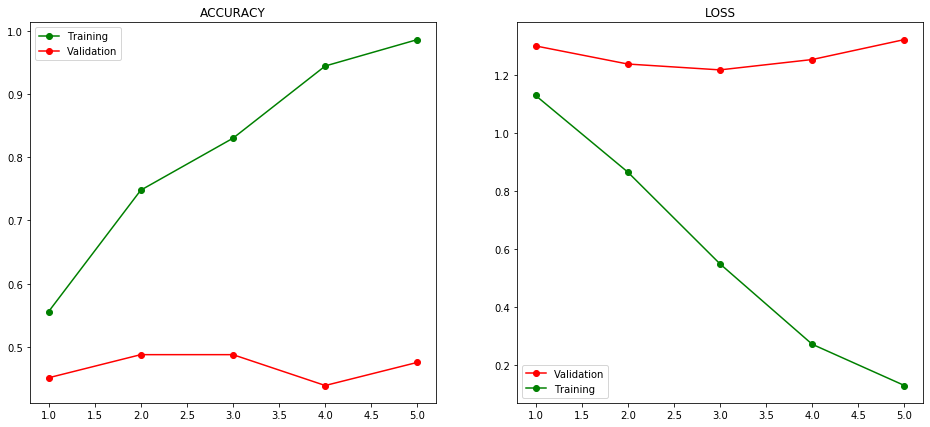

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       279
         NEU       1.00      0.93      0.96        84
        NONE       0.98      0.99      0.99       148
           P       0.98      0.99      0.98       207

   micro avg       0.99      0.99      0.99       718
   macro avg       0.99      0.98      0.98       718
weighted avg       0.99      0.99      0.99       718



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,0,1
NEU,1,78,2,3
NONE,0,0,147,1
P,1,0,1,205


### Validation

              precision    recall  f1-score   support

           N       0.47      0.62      0.53        32
         NEU       0.00      0.00      0.00        10
        NONE       0.32      0.35      0.33        17
           P       0.65      0.57      0.60        23

   micro avg       0.48      0.48      0.48        82
   macro avg       0.36      0.39      0.37        82
weighted avg       0.43      0.48      0.45        82



,N,NEU,NONE,P
Pred/True,,,,
N,20,0,8,4
NEU,6,0,2,2
NONE,10,0,6,1
P,7,0,3,13


### Fold number: 2. Name: 91ca901c8d9c4adf8b491abb49b5f6ff

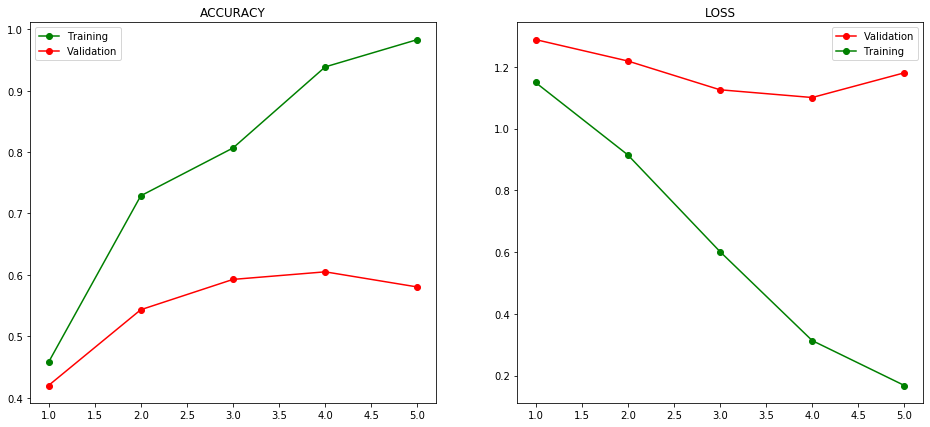

### Training

              precision    recall  f1-score   support

           N       1.00      0.99      0.99       280
         NEU       1.00      0.93      0.96        84
        NONE       0.94      1.00      0.97       148
           P       1.00      0.98      0.99       207

   micro avg       0.98      0.98      0.98       719
   macro avg       0.98      0.98      0.98       719
weighted avg       0.98      0.98      0.98       719



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,0,78,6,0
NONE,0,0,148,0
P,1,0,3,203


### Validation

              precision    recall  f1-score   support

           N       0.67      0.58      0.62        31
         NEU       0.00      0.00      0.00        10
        NONE       0.39      0.65      0.49        17
           P       0.69      0.78      0.73        23

   micro avg       0.58      0.58      0.58        81
   macro avg       0.44      0.50      0.46        81
weighted avg       0.53      0.58      0.55        81



,N,NEU,NONE,P
Pred/True,,,,
N,18,0,10,3
NEU,3,0,5,2
NONE,3,0,11,3
P,3,0,2,18


### Fold number: 3. Name: 0277f105d9be48aca8433059455bb064

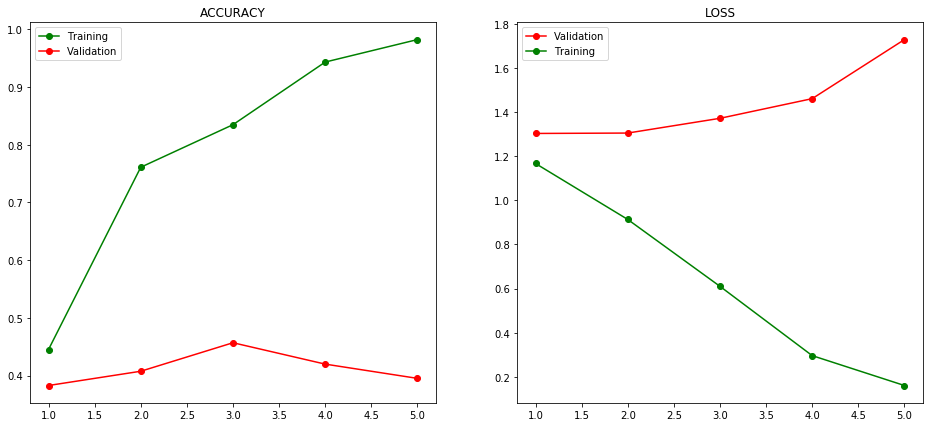

### Training

              precision    recall  f1-score   support

           N       1.00      0.98      0.99       280
         NEU       1.00      0.95      0.98        84
        NONE       0.95      0.99      0.97       148
           P       0.98      0.99      0.98       207

   micro avg       0.98      0.98      0.98       719
   macro avg       0.98      0.98      0.98       719
weighted avg       0.98      0.98      0.98       719



,N,NEU,NONE,P
Pred/True,,,,
N,275,0,2,3
NEU,0,80,3,1
NONE,0,0,147,1
P,1,0,2,204


### Validation

              precision    recall  f1-score   support

           N       0.53      0.32      0.40        31
         NEU       0.00      0.00      0.00        10
        NONE       0.28      0.65      0.39        17
           P       0.48      0.48      0.48        23

   micro avg       0.40      0.40      0.40        81
   macro avg       0.32      0.36      0.32        81
weighted avg       0.40      0.40      0.37        81



,N,NEU,NONE,P
Pred/True,,,,
N,10,0,15,6
NEU,2,0,5,3
NONE,3,0,11,3
P,4,0,8,11


### Fold number: 4. Name: 648c77a3838442d188e2ae2590b9d116

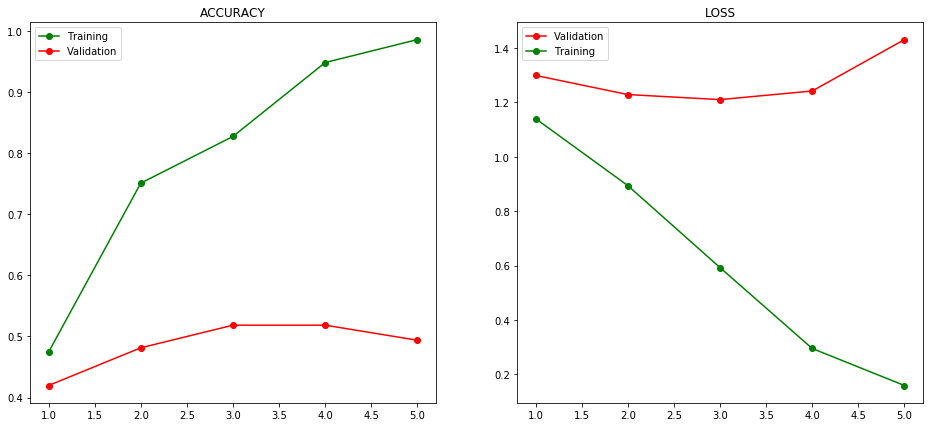

### Training

              precision    recall  f1-score   support

           N       1.00      0.99      0.99       280
         NEU       1.00      0.93      0.96        84
        NONE       0.96      0.99      0.98       148
           P       0.99      1.00      0.99       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.98      0.98       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,1,78,4,1
NONE,0,0,147,1
P,0,0,1,206


### Validation

              precision    recall  f1-score   support

           N       0.57      0.65      0.61        31
         NEU       0.00      0.00      0.00        10
        NONE       0.39      0.53      0.45        17
           P       0.50      0.48      0.49        23

   micro avg       0.49      0.49      0.49        81
   macro avg       0.37      0.41      0.39        81
weighted avg       0.44      0.49      0.47        81



,N,NEU,NONE,P
Pred/True,,,,
N,20,1,6,4
NEU,1,0,4,5
NONE,6,0,9,2
P,8,0,4,11


### Fold number: 5. Name: 2c4fdc87c88f4897bf91ab01ef8648a4

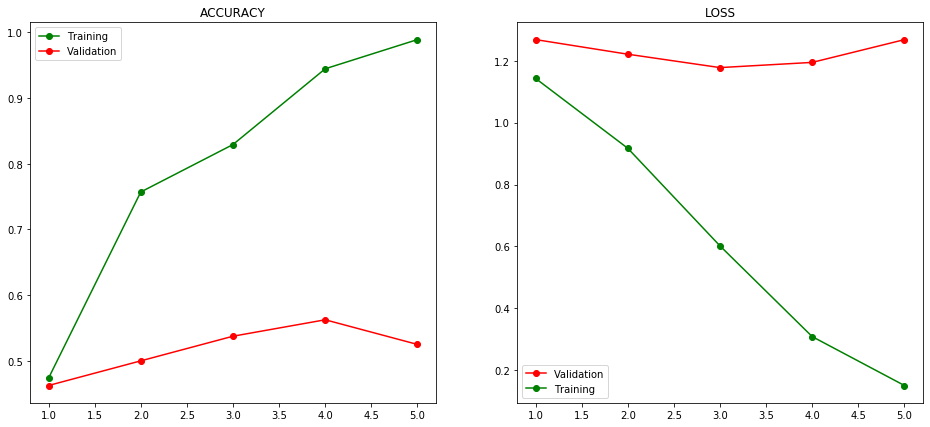

### Training

              precision    recall  f1-score   support

           N       1.00      0.99      0.99       280
         NEU       1.00      0.94      0.97        85
        NONE       0.97      1.00      0.99       148
           P       0.99      1.00      0.99       207

   micro avg       0.99      0.99      0.99       720
   macro avg       0.99      0.98      0.99       720
weighted avg       0.99      0.99      0.99       720



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,0,2
NEU,0,80,4,1
NONE,0,0,148,0
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.73      0.61      0.67        31
         NEU       0.00      0.00      0.00         9
        NONE       0.35      0.65      0.46        17
           P       0.55      0.52      0.53        23

   micro avg       0.53      0.53      0.53        80
   macro avg       0.41      0.45      0.41        80
weighted avg       0.52      0.53      0.51        80



,N,NEU,NONE,P
Pred/True,,,,
N,19,1,6,5
NEU,2,0,5,2
NONE,3,0,11,3
P,2,0,9,12


### Fold number: 6. Name: 6ef0e17d480242909d72a3048059934f

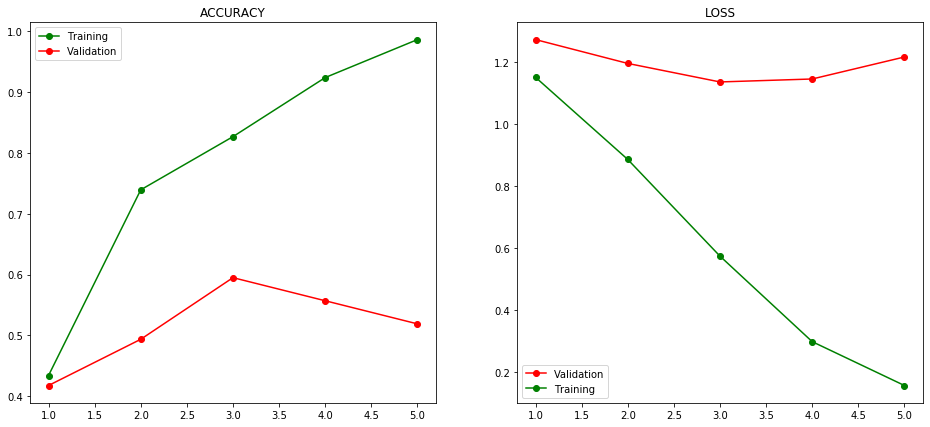

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.94      0.97        85
        NONE       0.97      0.98      0.98       149
           P       0.99      1.00      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.98      0.98       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,1,80,3,1
NONE,3,0,146,0
P,0,0,1,206


### Validation

              precision    recall  f1-score   support

           N       0.64      0.68      0.66        31
         NEU       0.00      0.00      0.00         9
        NONE       0.36      0.62      0.45        16
           P       0.59      0.43      0.50        23

   micro avg       0.52      0.52      0.52        79
   macro avg       0.40      0.43      0.40        79
weighted avg       0.49      0.52      0.50        79



,N,NEU,NONE,P
Pred/True,,,,
N,21,0,8,2
NEU,4,0,2,3
NONE,3,1,10,2
P,5,0,8,10


### Fold number: 7. Name: 39c69e79ca964cb89a739e1b55c2bf6f

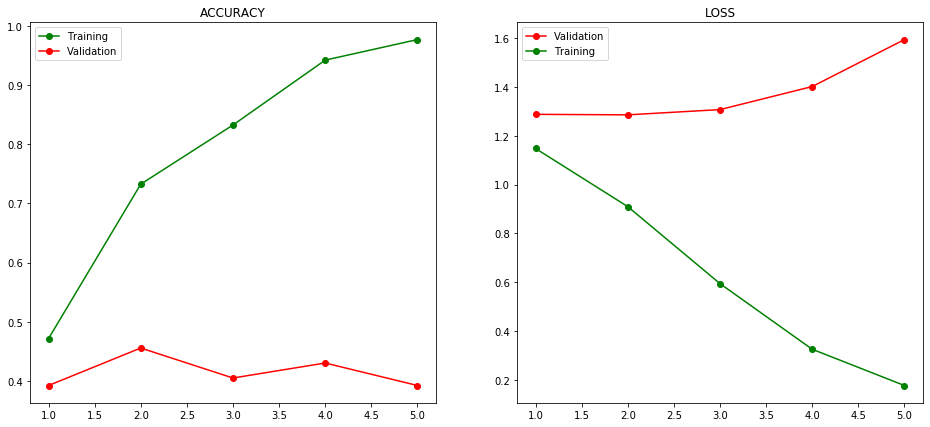

### Training

              precision    recall  f1-score   support

           N       0.97      1.00      0.98       280
         NEU       1.00      0.93      0.96        85
        NONE       0.95      0.97      0.96       149
           P       1.00      0.98      0.99       207

   micro avg       0.98      0.98      0.98       721
   macro avg       0.98      0.97      0.97       721
weighted avg       0.98      0.98      0.98       721



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,1,79,5,0
NONE,5,0,144,0
P,2,0,3,202


### Validation

              precision    recall  f1-score   support

           N       0.61      0.45      0.52        31
         NEU       0.00      0.00      0.00         9
        NONE       0.26      0.62      0.36        16
           P       0.41      0.30      0.35        23

   micro avg       0.39      0.39      0.39        79
   macro avg       0.32      0.35      0.31        79
weighted avg       0.41      0.39      0.38        79



,N,NEU,NONE,P
Pred/True,,,,
N,14,0,14,3
NEU,2,0,5,2
NONE,1,0,10,5
P,6,0,10,7


### Fold number: 8. Name: bf27be664c0d4d159ea00040a0de755b

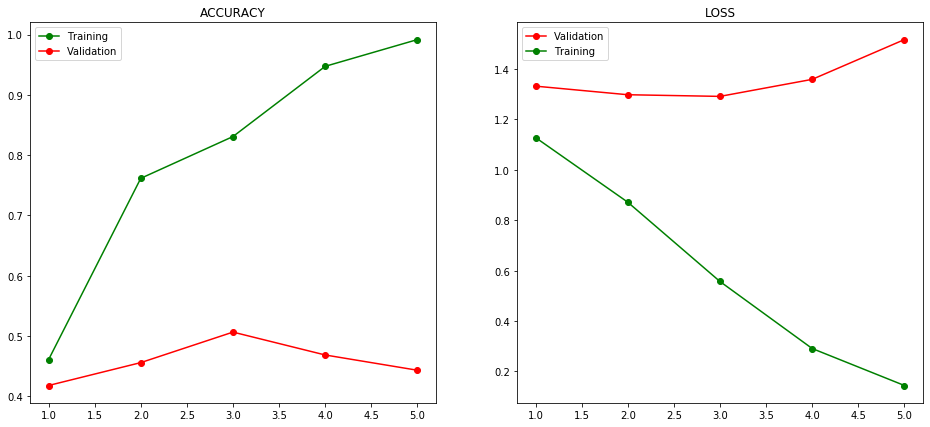

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.96      0.98        85
        NONE       0.98      0.99      0.98       149
           P       1.00      1.00      1.00       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.99      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,1,82,2,0
NONE,2,0,147,0
P,0,0,1,206


### Validation

              precision    recall  f1-score   support

           N       0.56      0.61      0.58        31
         NEU       0.00      0.00      0.00         9
        NONE       0.26      0.38      0.31        16
           P       0.48      0.43      0.45        23

   micro avg       0.44      0.44      0.44        79
   macro avg       0.32      0.36      0.34        79
weighted avg       0.41      0.44      0.42        79



,N,NEU,NONE,P
Pred/True,,,,
N,19,0,6,6
NEU,3,0,3,3
NONE,7,1,6,2
P,5,0,8,10


### Fold number: 9. Name: b6da1c7deac04bd2b7a0b479ee4f4d0a

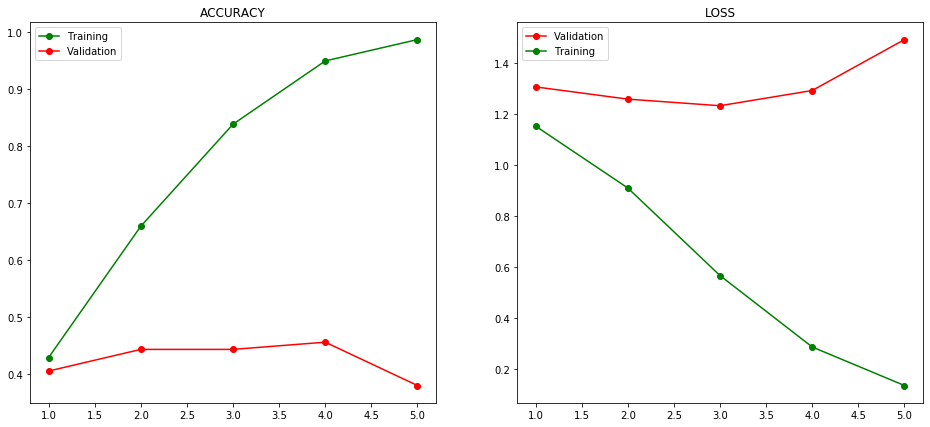

### Training

              precision    recall  f1-score   support

           N       0.98      0.99      0.99       280
         NEU       1.00      0.94      0.97        85
        NONE       0.99      0.99      0.99       149
           P       0.99      1.00      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.98      0.98       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,0,2
NEU,2,80,2,1
NONE,2,0,147,0
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.48      0.39      0.43        31
         NEU       0.00      0.00      0.00         9
        NONE       0.29      0.62      0.40        16
           P       0.42      0.35      0.38        23

   micro avg       0.38      0.38      0.38        79
   macro avg       0.30      0.34      0.30        79
weighted avg       0.37      0.38      0.36        79



,N,NEU,NONE,P
Pred/True,,,,
N,12,0,12,7
NEU,3,0,5,1
NONE,3,0,10,3
P,7,1,7,8


### Fold number: 10. Name: 9b9e76a9c7314ff3b8016e1333928d66

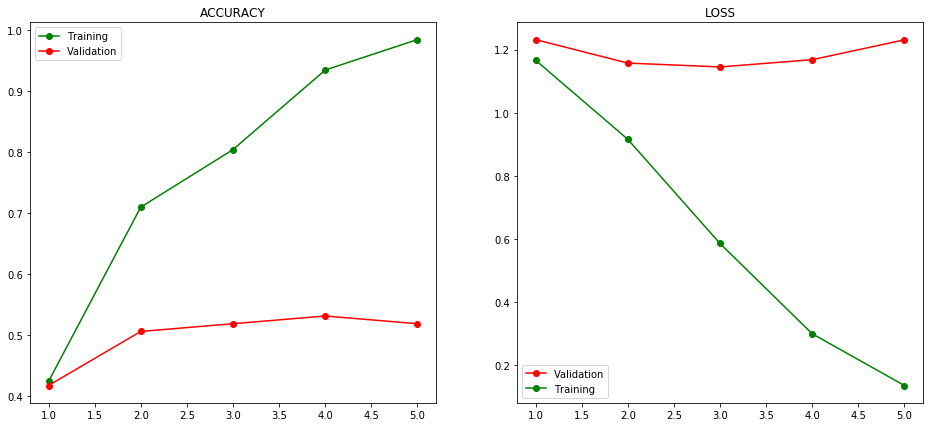

### Training

              precision    recall  f1-score   support

           N       0.98      0.99      0.98       280
         NEU       1.00      0.96      0.98        85
        NONE       0.99      0.98      0.98       149
           P       0.99      0.99      0.99       207

   micro avg       0.98      0.98      0.98       721
   macro avg       0.99      0.98      0.98       721
weighted avg       0.98      0.98      0.98       721



,N,NEU,NONE,P
Pred/True,,,,
N,277,0,1,2
NEU,2,82,1,0
NONE,2,0,146,1
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.51      0.74      0.61        31
         NEU       0.00      0.00      0.00         9
        NONE       0.67      0.12      0.21        16
           P       0.52      0.70      0.59        23

   micro avg       0.52      0.52      0.52        79
   macro avg       0.42      0.39      0.35        79
weighted avg       0.49      0.52      0.45        79



,N,NEU,NONE,P
Pred/True,,,,
N,23,0,1,7
NEU,7,0,0,2
NONE,8,0,2,6
P,7,0,0,16


## 2. CorpusFBCR2013.txt.usu.sw.kvs

### Fold number: 1. Name: df884a4b4bd4451192cd17748c568c38

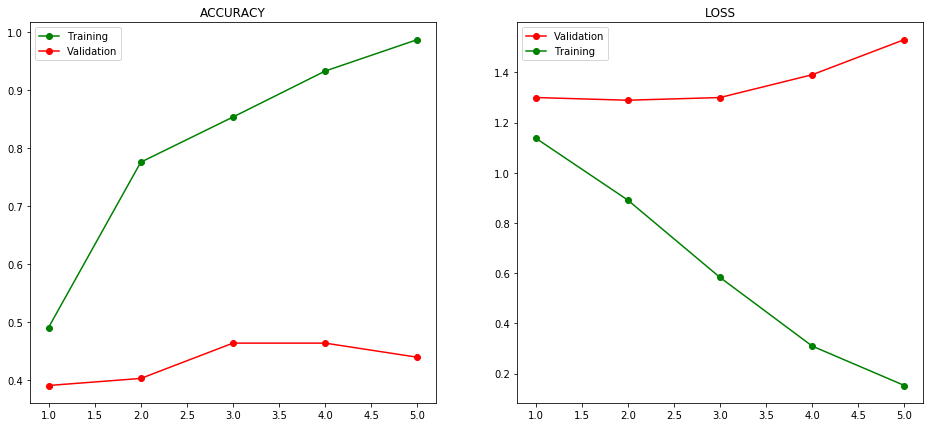

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       279
         NEU       1.00      0.93      0.96        84
        NONE       0.98      0.99      0.99       148
           P       0.99      1.00      0.99       207

   micro avg       0.99      0.99      0.99       718
   macro avg       0.99      0.98      0.98       718
weighted avg       0.99      0.99      0.99       718



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,0,1
NEU,1,78,3,2
NONE,1,0,147,0
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.61      0.44      0.51        32
         NEU       0.00      0.00      0.00        10
        NONE       0.35      0.82      0.49        17
           P       0.42      0.35      0.38        23

   micro avg       0.44      0.44      0.44        82
   macro avg       0.34      0.40      0.35        82
weighted avg       0.43      0.44      0.41        82



,N,NEU,NONE,P
Pred/True,,,,
N,14,0,12,6
NEU,2,0,4,4
NONE,2,0,14,1
P,5,0,10,8


### Fold number: 2. Name: 0c7c0b1f458b4f1ca2c05569525d63dc

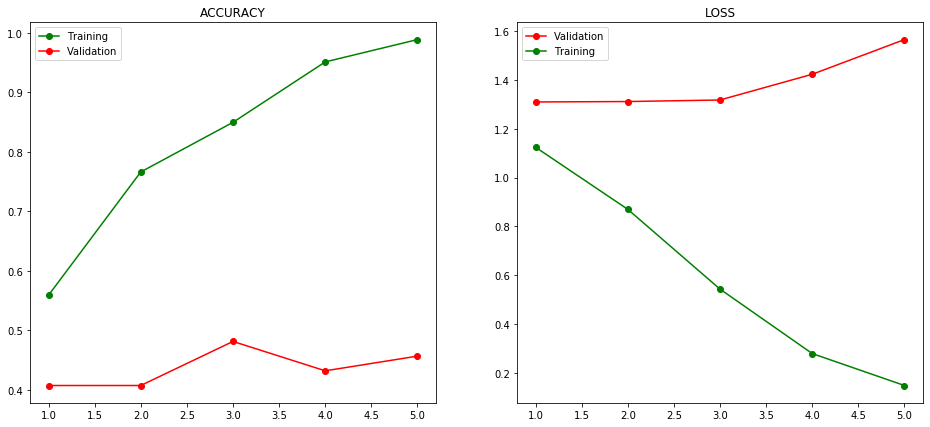

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.94      0.97        84
        NONE       0.97      0.99      0.98       148
           P       0.99      1.00      0.99       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.98      0.99       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,1,79,4,0
NONE,0,0,147,1
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.46      0.42      0.44        31
         NEU       0.00      0.00      0.00        10
        NONE       0.31      0.59      0.41        17
           P       0.67      0.61      0.64        23

   micro avg       0.46      0.46      0.46        81
   macro avg       0.36      0.40      0.37        81
weighted avg       0.43      0.46      0.44        81



,N,NEU,NONE,P
Pred/True,,,,
N,13,0,14,4
NEU,7,0,2,1
NONE,5,0,10,2
P,3,0,6,14


### Fold number: 3. Name: 7f086accfa1044f7b7a2f26c9656b991

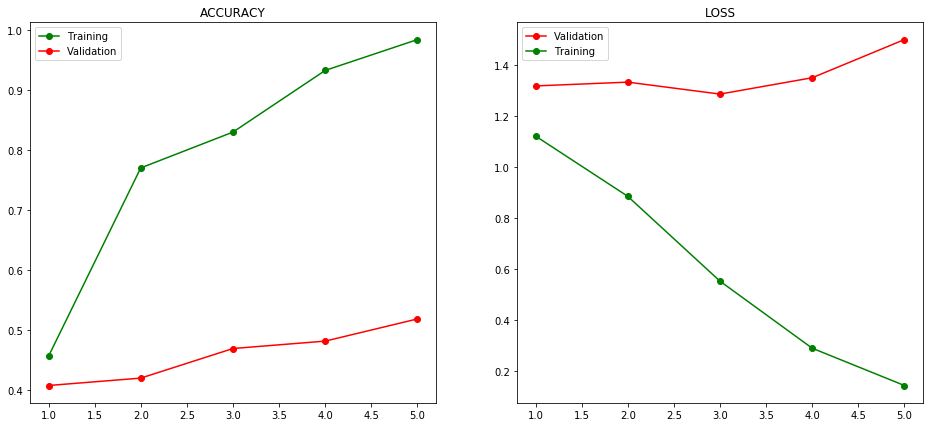

### Training

              precision    recall  f1-score   support

           N       0.98      1.00      0.99       280
         NEU       1.00      0.92      0.96        84
        NONE       0.97      0.99      0.98       148
           P       0.99      0.99      0.99       207

   micro avg       0.98      0.98      0.98       719
   macro avg       0.99      0.97      0.98       719
weighted avg       0.98      0.98      0.98       719



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,77,3,2
NONE,1,0,147,0
P,2,0,1,204


### Validation

              precision    recall  f1-score   support

           N       0.55      0.68      0.61        31
         NEU       1.00      0.10      0.18        10
        NONE       0.43      0.59      0.50        17
           P       0.53      0.43      0.48        23

   micro avg       0.52      0.52      0.52        81
   macro avg       0.63      0.45      0.44        81
weighted avg       0.58      0.52      0.50        81



,N,NEU,NONE,P
Pred/True,,,,
N,21,0,4,6
NEU,5,1,4,0
NONE,4,0,10,3
P,8,0,5,10


### Fold number: 4. Name: 6998b1fdd59a45bfbb6a54a65d3ab9e5

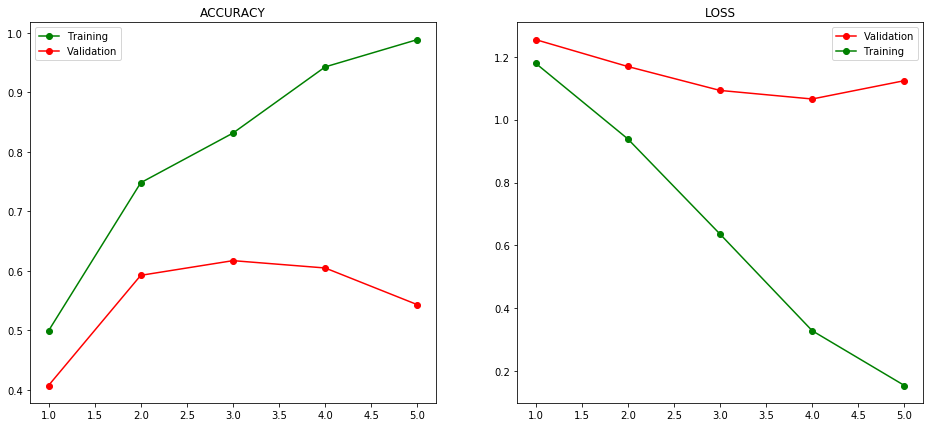

### Training

              precision    recall  f1-score   support

           N       0.98      1.00      0.99       280
         NEU       1.00      0.98      0.99        84
        NONE       0.99      0.98      0.98       148
           P       1.00      0.99      0.99       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.99      0.99       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,0,82,2,0
NONE,3,0,145,0
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.62      0.65      0.63        31
         NEU       0.00      0.00      0.00        10
        NONE       0.41      0.71      0.52        17
           P       0.60      0.52      0.56        23

   micro avg       0.54      0.54      0.54        81
   macro avg       0.41      0.47      0.43        81
weighted avg       0.50      0.54      0.51        81



,N,NEU,NONE,P
Pred/True,,,,
N,20,0,8,3
NEU,5,0,2,3
NONE,3,0,12,2
P,4,0,7,12


### Fold number: 5. Name: 52ef9ff2f19a472aad1407c06740386d

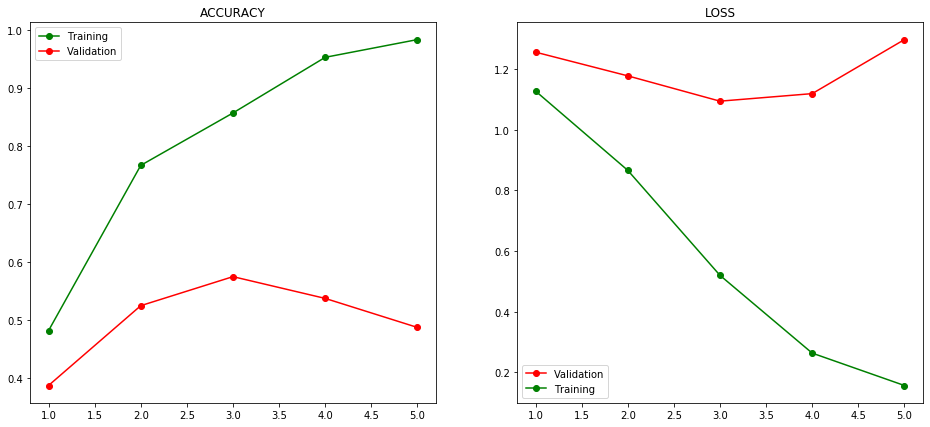

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.89      0.94        85
        NONE       0.95      1.00      0.97       148
           P       0.99      0.99      0.99       207

   micro avg       0.98      0.98      0.98       720
   macro avg       0.98      0.97      0.98       720
weighted avg       0.98      0.98      0.98       720



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,1,76,7,1
NONE,0,0,148,0
P,1,0,1,205


### Validation

              precision    recall  f1-score   support

           N       0.71      0.48      0.58        31
         NEU       0.00      0.00      0.00         9
        NONE       0.34      0.82      0.48        17
           P       0.56      0.43      0.49        23

   micro avg       0.49      0.49      0.49        80
   macro avg       0.40      0.44      0.39        80
weighted avg       0.51      0.49      0.47        80



,N,NEU,NONE,P
Pred/True,,,,
N,15,0,13,3
NEU,2,0,3,4
NONE,2,0,14,1
P,2,0,11,10


### Fold number: 6. Name: 107106be894d47e3867b2b08d78d7674

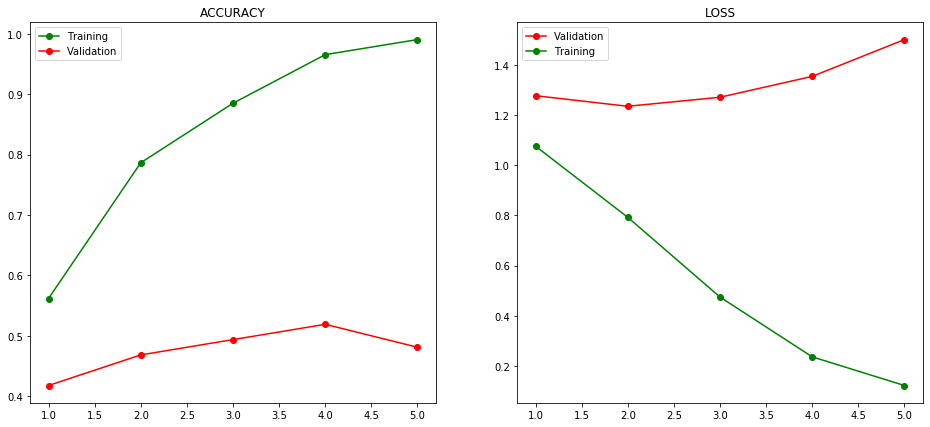

### Training

              precision    recall  f1-score   support

           N       0.98      1.00      0.99       280
         NEU       1.00      0.95      0.98        85
        NONE       0.99      0.99      0.99       149
           P       1.00      0.99      1.00       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.98      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,3,81,1,0
NONE,1,0,148,0
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.47      0.74      0.58        31
         NEU       0.00      0.00      0.00         9
        NONE       0.45      0.31      0.37        16
           P       0.53      0.43      0.48        23

   micro avg       0.48      0.48      0.48        79
   macro avg       0.36      0.37      0.36        79
weighted avg       0.43      0.48      0.44        79



,N,NEU,NONE,P
Pred/True,,,,
N,23,0,4,4
NEU,4,0,0,5
NONE,11,0,5,0
P,11,0,2,10


### Fold number: 7. Name: 1eed4761d13d42829482264ce709b1f3

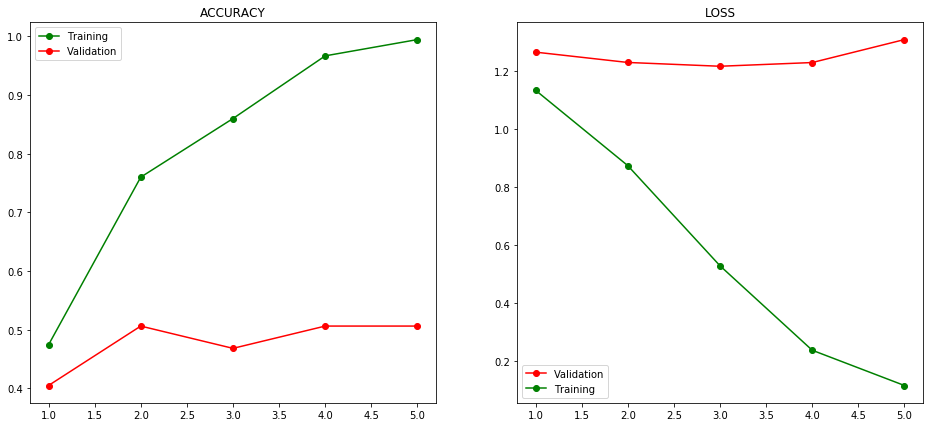

### Training

              precision    recall  f1-score   support

           N       1.00      1.00      1.00       280
         NEU       1.00      0.98      0.99        85
        NONE       0.99      0.99      0.99       149
           P       1.00      1.00      1.00       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.99      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,0,83,2,0
NONE,1,0,148,0
P,0,0,0,207


### Validation

              precision    recall  f1-score   support

           N       0.54      0.71      0.61        31
         NEU       0.00      0.00      0.00         9
        NONE       0.43      0.56      0.49        16
           P       0.53      0.39      0.45        23

   micro avg       0.51      0.51      0.51        79
   macro avg       0.37      0.42      0.39        79
weighted avg       0.45      0.51      0.47        79



,N,NEU,NONE,P
Pred/True,,,,
N,22,0,5,4
NEU,5,0,2,2
NONE,5,0,9,2
P,9,0,5,9


### Fold number: 8. Name: c1689b43cc7a4bc28a58d9a064095d76

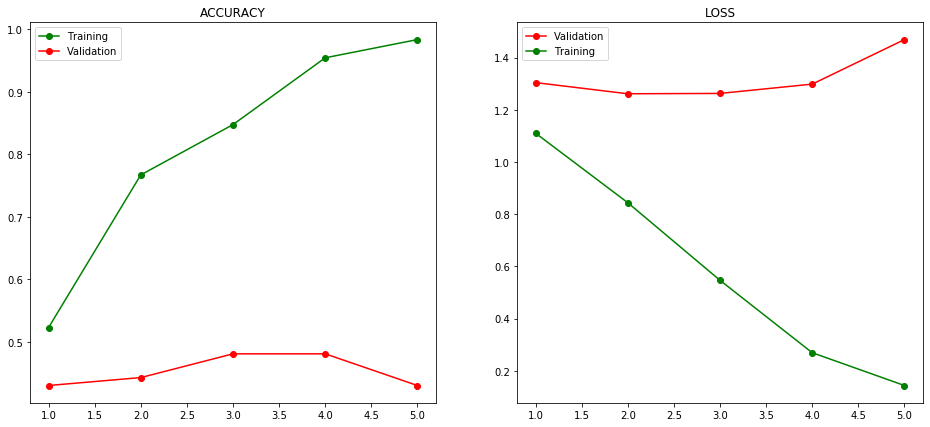

### Training

              precision    recall  f1-score   support

           N       1.00      0.99      0.99       280
         NEU       1.00      0.95      0.98        85
        NONE       0.99      0.97      0.98       149
           P       0.96      1.00      0.98       207

   micro avg       0.98      0.98      0.98       721
   macro avg       0.99      0.98      0.98       721
weighted avg       0.98      0.98      0.98       721



,N,NEU,NONE,P
Pred/True,,,,
N,277,0,0,3
NEU,0,81,2,2
NONE,0,0,145,4
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.61      0.55      0.58        31
         NEU       0.00      0.00      0.00         9
        NONE       0.23      0.38      0.29        16
           P       0.48      0.48      0.48        23

   micro avg       0.43      0.43      0.43        79
   macro avg       0.33      0.35      0.34        79
weighted avg       0.42      0.43      0.42        79



,N,NEU,NONE,P
Pred/True,,,,
N,17,0,9,5
NEU,1,0,5,3
NONE,5,1,6,4
P,5,1,6,11


### Fold number: 9. Name: 531f785f42304d8fa2036d81885882f3

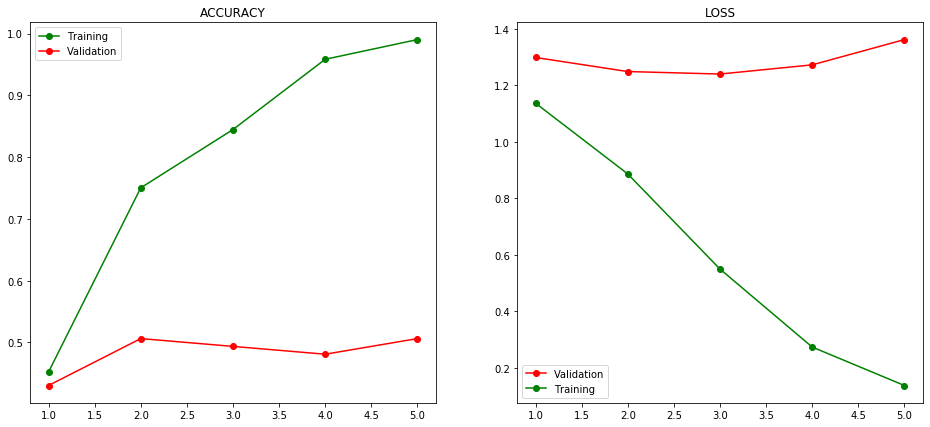

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.96      0.98        85
        NONE       0.97      0.99      0.98       149
           P       1.00      0.99      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.99      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,0,82,3,0
NONE,1,0,148,0
P,1,0,1,205


### Validation

              precision    recall  f1-score   support

           N       0.61      0.61      0.61        31
         NEU       0.00      0.00      0.00         9
        NONE       0.33      0.50      0.40        16
           P       0.65      0.57      0.60        23

   micro avg       0.51      0.51      0.51        79
   macro avg       0.40      0.42      0.40        79
weighted avg       0.50      0.51      0.50        79



,N,NEU,NONE,P
Pred/True,,,,
N,19,2,10,0
NEU,2,0,5,2
NONE,3,0,8,5
P,7,2,1,13


### Fold number: 10. Name: 5ff0422e1e0a45abb0276d7519a065a9

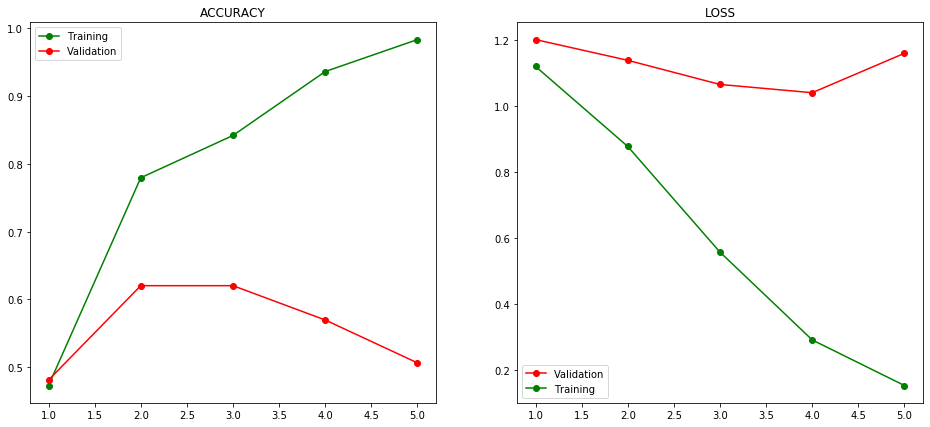

### Training

              precision    recall  f1-score   support

           N       0.99      0.99      0.99       280
         NEU       1.00      0.89      0.94        85
        NONE       0.98      1.00      0.99       149
           P       0.97      1.00      0.98       207

   micro avg       0.98      0.98      0.98       721
   macro avg       0.99      0.97      0.98       721
weighted avg       0.98      0.98      0.98       721



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,0,2
NEU,2,76,3,4
NONE,0,0,149,0
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.70      0.45      0.55        31
         NEU       0.00      0.00      0.00         9
        NONE       0.37      0.62      0.47        16
           P       0.52      0.70      0.59        23

   micro avg       0.51      0.51      0.51        79
   macro avg       0.40      0.44      0.40        79
weighted avg       0.50      0.51      0.48        79



,N,NEU,NONE,P
Pred/True,,,,
N,14,1,9,7
NEU,2,0,4,3
NONE,1,0,10,5
P,3,0,4,16


## 3. tweets.txt.usu.bw.kvs

### Fold number: 1. Name: b2d05dccbb6e490881df2d1d0da1601c

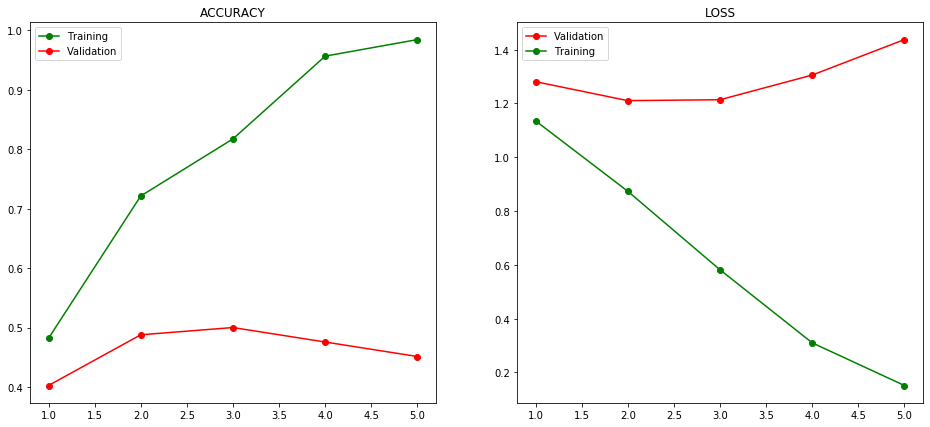

### Training

              precision    recall  f1-score   support

           N       0.98      1.00      0.99       279
         NEU       1.00      0.90      0.95        84
        NONE       0.97      0.99      0.98       148
           P       1.00      0.99      0.99       207

   micro avg       0.98      0.98      0.98       718
   macro avg       0.99      0.97      0.98       718
weighted avg       0.98      0.98      0.98       718



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,0
NEU,4,76,4,0
NONE,0,0,147,1
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.55      0.66      0.60        32
         NEU       0.00      0.00      0.00        10
        NONE       0.29      0.41      0.34        17
           P       0.45      0.39      0.42        23

   micro avg       0.45      0.45      0.45        82
   macro avg       0.32      0.36      0.34        82
weighted avg       0.40      0.45      0.42        82



,N,NEU,NONE,P
Pred/True,,,,
N,21,0,7,4
NEU,4,0,3,3
NONE,6,0,7,4
P,7,0,7,9


### Fold number: 2. Name: 1840d9e3391142e28f3640d2839d28ff

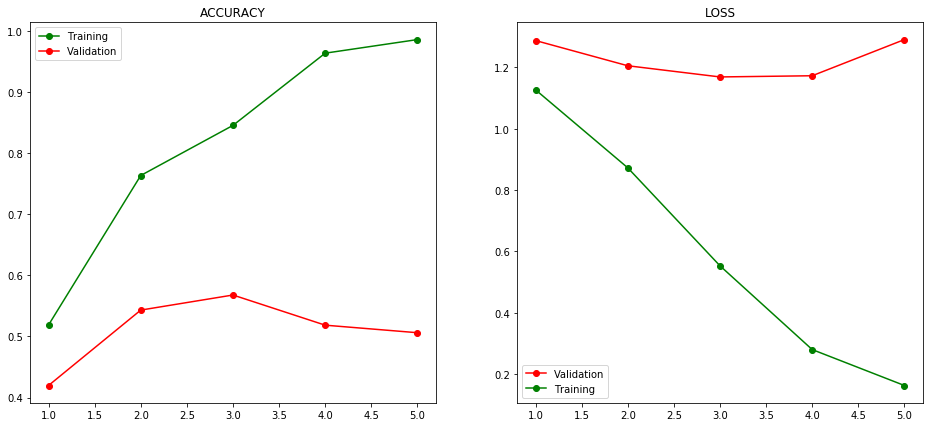

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.93      0.96        84
        NONE       0.97      0.99      0.98       148
           P       0.99      0.99      0.99       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.98      0.98       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,2,78,4,0
NONE,0,0,147,1
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.76      0.52      0.62        31
         NEU       0.00      0.00      0.00        10
        NONE       0.35      0.65      0.46        17
           P       0.48      0.61      0.54        23

   micro avg       0.51      0.51      0.51        81
   macro avg       0.40      0.44      0.40        81
weighted avg       0.50      0.51      0.48        81



,N,NEU,NONE,P
Pred/True,,,,
N,16,0,9,6
NEU,1,0,4,5
NONE,2,0,11,4
P,2,0,7,14


### Fold number: 3. Name: 62c99427564541f18c690dd296a49010

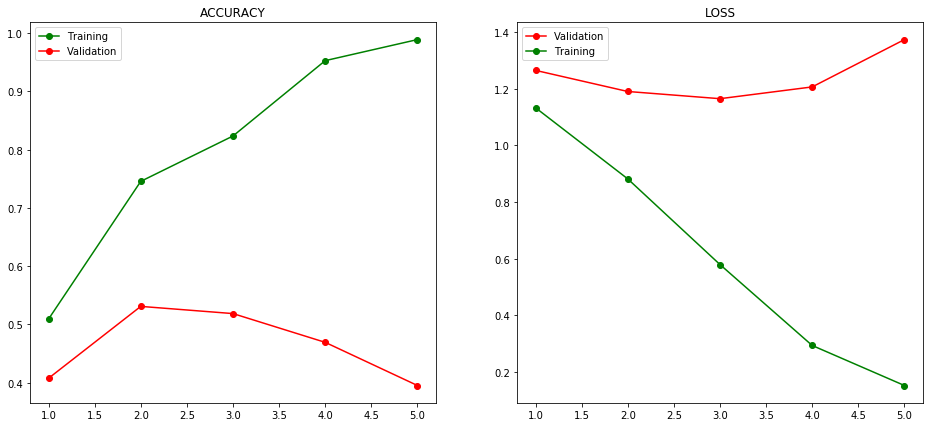

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.93      0.96        84
        NONE       0.98      0.99      0.99       148
           P       1.00      1.00      1.00       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.98      0.98       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,3,78,3,0
NONE,0,0,147,1
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.46      0.39      0.42        31
         NEU       0.00      0.00      0.00        10
        NONE       0.28      0.59      0.38        17
           P       0.56      0.43      0.49        23

   micro avg       0.40      0.40      0.40        81
   macro avg       0.32      0.35      0.32        81
weighted avg       0.39      0.40      0.38        81



,N,NEU,NONE,P
Pred/True,,,,
N,12,0,17,2
NEU,4,0,3,3
NONE,3,1,10,3
P,7,0,6,10


### Fold number: 4. Name: d47dd0a08c5c4354a4e81a7ea62973e4

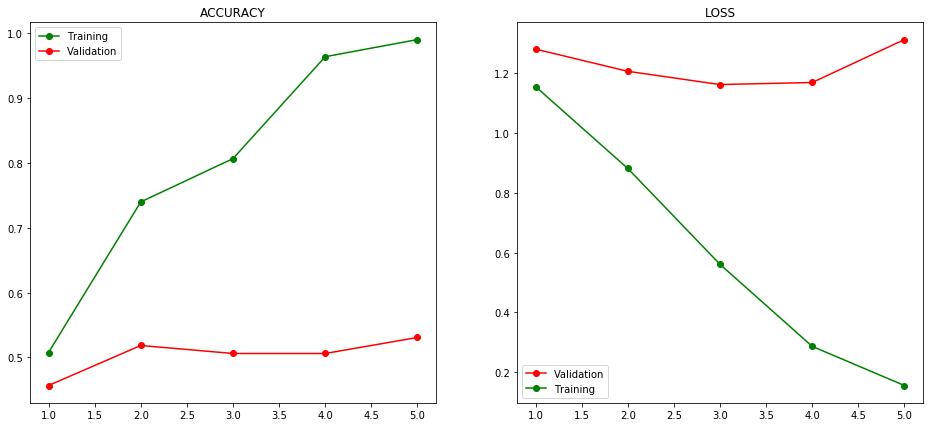

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.95      0.98        84
        NONE       0.99      0.99      0.99       148
           P       0.99      1.00      0.99       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.98      0.99       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,1,80,2,1
NONE,1,0,147,0
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.70      0.52      0.59        31
         NEU       0.00      0.00      0.00        10
        NONE       0.44      0.47      0.46        17
           P       0.47      0.83      0.60        23

   micro avg       0.53      0.53      0.53        81
   macro avg       0.40      0.45      0.41        81
weighted avg       0.49      0.53      0.49        81



,N,NEU,NONE,P
Pred/True,,,,
N,16,0,4,11
NEU,3,0,3,4
NONE,3,0,8,6
P,1,0,3,19


### Fold number: 5. Name: 4dba8575c6a74d9da0a349e07c9d1687

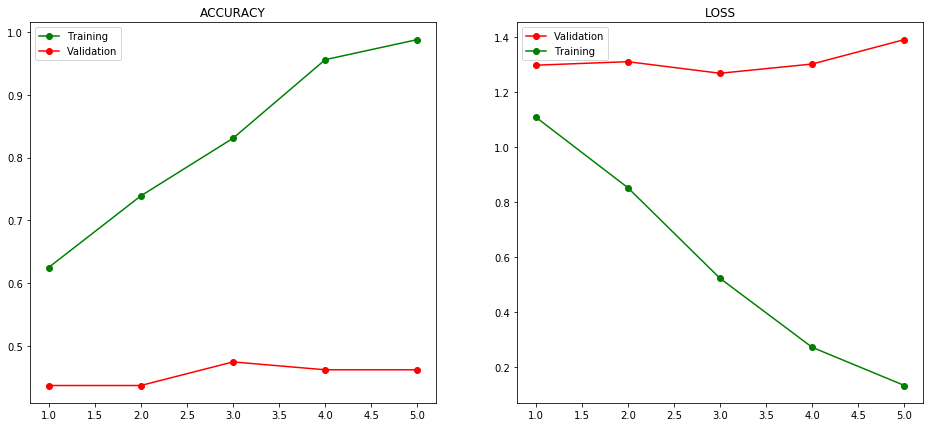

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.93      0.96        85
        NONE       0.99      0.99      0.99       148
           P       0.98      1.00      0.99       207

   micro avg       0.99      0.99      0.99       720
   macro avg       0.99      0.98      0.98       720
weighted avg       0.99      0.99      0.99       720



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,79,2,2
NONE,0,0,146,2
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.57      0.52      0.54        31
         NEU       0.00      0.00      0.00         9
        NONE       0.32      0.41      0.36        17
           P       0.47      0.61      0.53        23

   micro avg       0.46      0.46      0.46        80
   macro avg       0.34      0.38      0.36        80
weighted avg       0.42      0.46      0.44        80



,N,NEU,NONE,P
Pred/True,,,,
N,16,0,9,6
NEU,0,0,4,5
NONE,5,0,7,5
P,7,0,2,14


### Fold number: 6. Name: 0508f4a71bc847809875f7fcd3b0592b

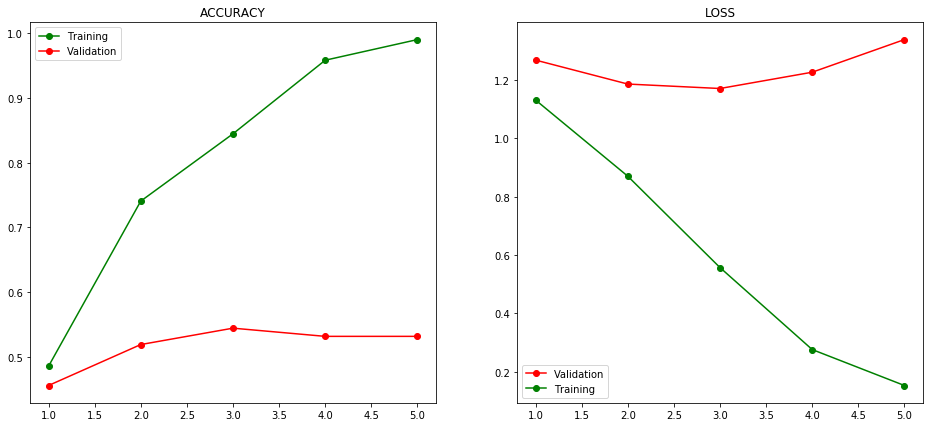

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.96      0.98        85
        NONE       0.99      0.99      0.99       149
           P       0.99      0.99      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.99      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,1,82,2,0
NONE,0,0,148,1
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.63      0.61      0.62        31
         NEU       0.00      0.00      0.00         9
        NONE       0.31      0.62      0.42        16
           P       0.76      0.57      0.65        23

   micro avg       0.53      0.53      0.53        79
   macro avg       0.43      0.45      0.42        79
weighted avg       0.53      0.53      0.52        79



,N,NEU,NONE,P
Pred/True,,,,
N,19,0,10,2
NEU,3,0,6,0
NONE,4,0,10,2
P,4,0,6,13


### Fold number: 7. Name: 2700eafc2e2947a080a253fd09f47815

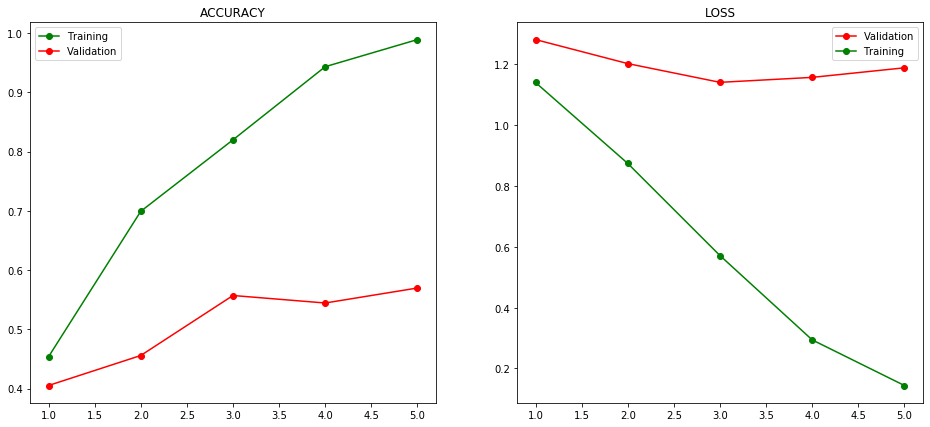

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.95      0.98        85
        NONE       0.98      0.99      0.99       149
           P       1.00      0.99      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.98      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,81,2,0
NONE,0,0,148,1
P,2,0,1,204


### Validation

              precision    recall  f1-score   support

           N       0.64      0.74      0.69        31
         NEU       0.00      0.00      0.00         9
        NONE       0.42      0.50      0.46        16
           P       0.61      0.61      0.61        23

   micro avg       0.57      0.57      0.57        79
   macro avg       0.42      0.46      0.44        79
weighted avg       0.51      0.57      0.54        79



,N,NEU,NONE,P
Pred/True,,,,
N,23,0,5,3
NEU,5,0,1,3
NONE,5,0,8,3
P,3,1,5,14


### Fold number: 8. Name: 303df17a018040d39960e5b593fe4c8d

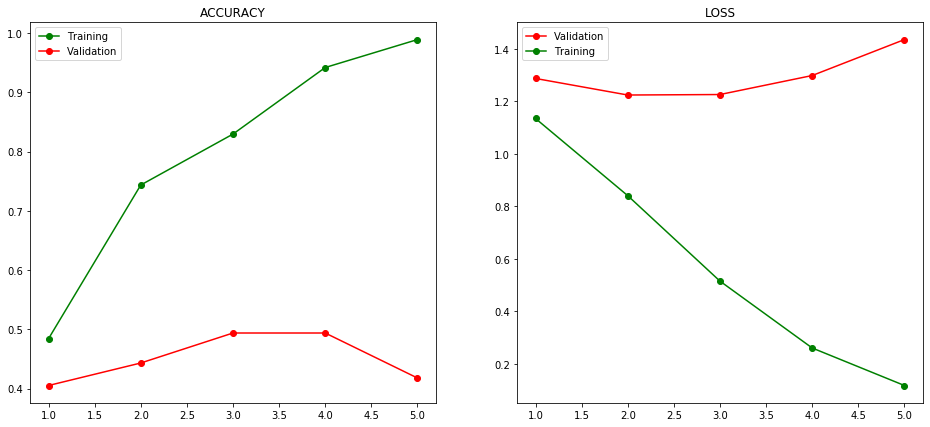

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.94      0.97        85
        NONE       0.97      0.99      0.98       149
           P       1.00      0.99      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.98      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,80,3,0
NONE,0,0,148,1
P,1,0,1,205


### Validation

              precision    recall  f1-score   support

           N       0.54      0.45      0.49        31
         NEU       0.00      0.00      0.00         9
        NONE       0.26      0.56      0.36        16
           P       0.53      0.43      0.48        23

   micro avg       0.42      0.42      0.42        79
   macro avg       0.33      0.36      0.33        79
weighted avg       0.42      0.42      0.40        79



,N,NEU,NONE,P
Pred/True,,,,
N,14,0,10,7
NEU,5,0,4,0
NONE,5,0,9,2
P,2,0,11,10


### Fold number: 9. Name: cb710884062b40baa21b25246bbcff4f

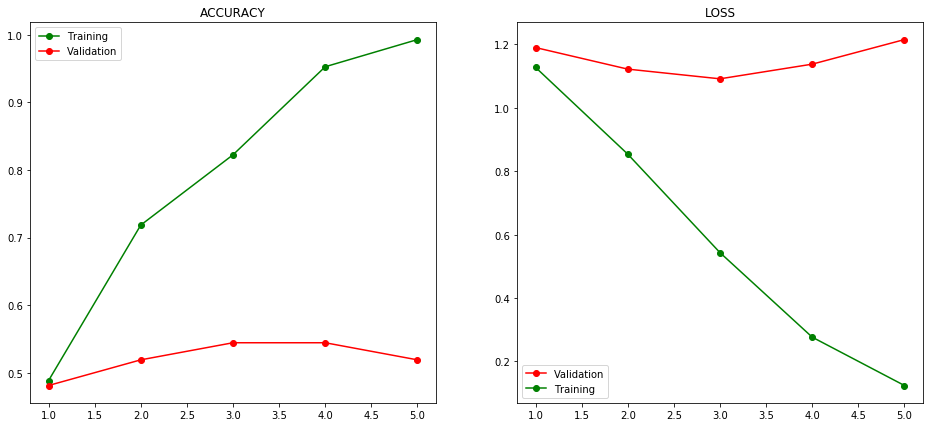

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      1.00       280
         NEU       1.00      0.96      0.98        85
        NONE       1.00      0.99      1.00       149
           P       0.99      1.00      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.99      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,1,82,0,2
NONE,0,0,148,1
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.61      0.65      0.62        31
         NEU       0.00      0.00      0.00         9
        NONE       0.46      0.38      0.41        16
           P       0.48      0.65      0.56        23

   micro avg       0.52      0.52      0.52        79
   macro avg       0.39      0.42      0.40        79
weighted avg       0.47      0.52      0.49        79



,N,NEU,NONE,P
Pred/True,,,,
N,20,1,4,6
NEU,4,0,2,3
NONE,2,1,6,7
P,7,0,1,15


### Fold number: 10. Name: da918b2ac09742c1aeb14bc8746f7501

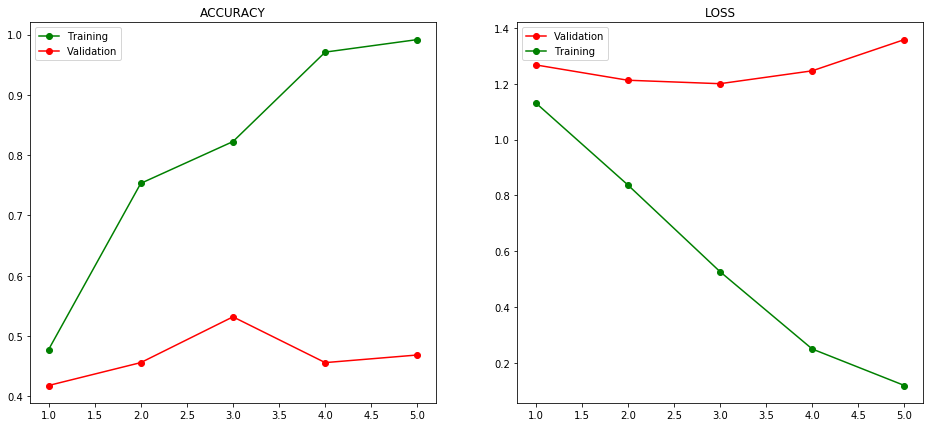

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.96      0.98        85
        NONE       0.99      0.99      0.99       149
           P       1.00      0.99      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.99      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,82,1,0
NONE,0,0,148,1
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.53      0.58      0.55        31
         NEU       1.00      0.11      0.20         9
        NONE       0.20      0.25      0.22        16
           P       0.58      0.61      0.60        23

   micro avg       0.47      0.47      0.47        79
   macro avg       0.58      0.39      0.39        79
weighted avg       0.53      0.47      0.46        79



,N,NEU,NONE,P
Pred/True,,,,
N,18,0,6,7
NEU,3,1,4,1
NONE,10,0,4,2
P,3,0,6,14


## 4. tweets.txt.usu.sw.kvs

### Fold number: 1. Name: 7007407a11104fe39212aa2db614b89e

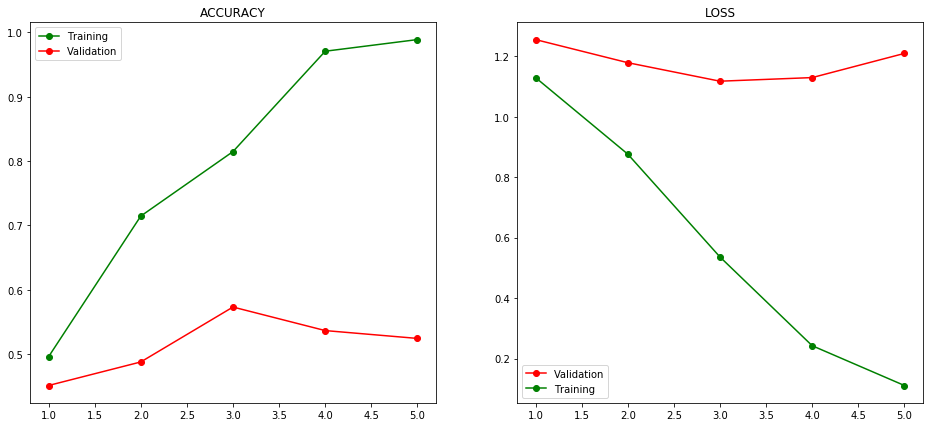

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       279
         NEU       1.00      0.93      0.96        84
        NONE       0.97      0.99      0.98       148
           P       1.00      1.00      1.00       207

   micro avg       0.99      0.99      0.99       718
   macro avg       0.99      0.98      0.98       718
weighted avg       0.99      0.99      0.99       718



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,0
NEU,2,78,4,0
NONE,0,0,147,1
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.56      0.69      0.62        32
         NEU       0.00      0.00      0.00        10
        NONE       0.42      0.59      0.49        17
           P       0.58      0.48      0.52        23

   micro avg       0.52      0.52      0.52        82
   macro avg       0.39      0.44      0.41        82
weighted avg       0.47      0.52      0.49        82



,N,NEU,NONE,P
Pred/True,,,,
N,22,0,5,5
NEU,8,0,1,1
NONE,5,0,10,2
P,4,0,8,11


### Fold number: 2. Name: e164bc035b6842d5aa0fd2d60cd5800d

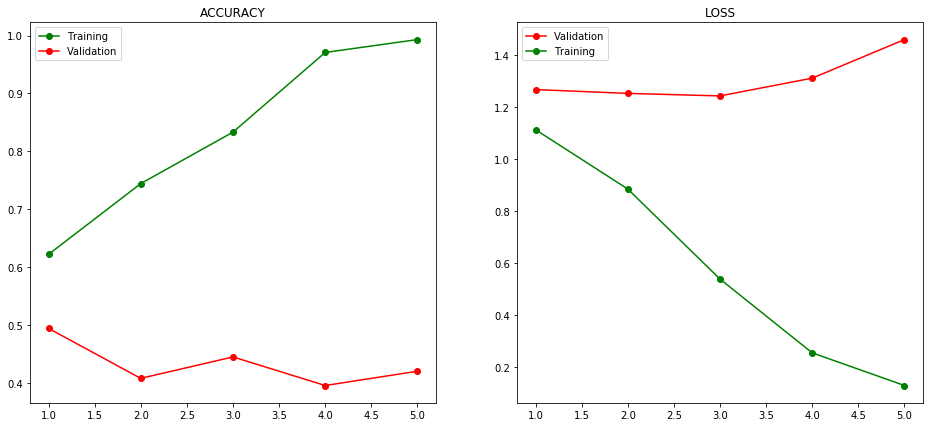

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.96      0.98        84
        NONE       0.99      0.99      0.99       148
           P       1.00      1.00      1.00       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.99      0.99       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,81,1,0
NONE,0,0,147,1
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.52      0.45      0.48        31
         NEU       0.33      0.10      0.15        10
        NONE       0.32      0.41      0.36        17
           P       0.41      0.52      0.46        23

   micro avg       0.42      0.42      0.42        81
   macro avg       0.40      0.37      0.36        81
weighted avg       0.42      0.42      0.41        81



,N,NEU,NONE,P
Pred/True,,,,
N,14,1,9,7
NEU,3,1,2,4
NONE,3,1,7,6
P,7,0,4,12


### Fold number: 3. Name: e3f278283d2f4b468dc7100e14ef7a8a

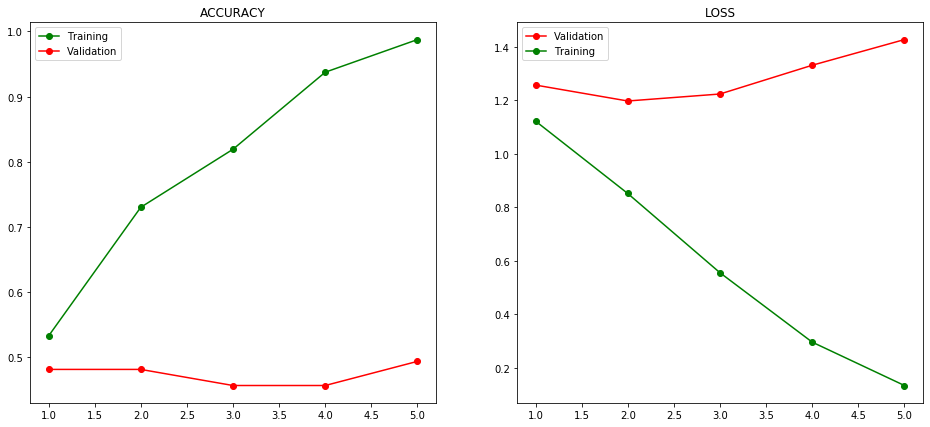

### Training

              precision    recall  f1-score   support

           N       0.98      1.00      0.99       280
         NEU       1.00      0.96      0.98        84
        NONE       0.99      0.98      0.98       148
           P       1.00      0.99      0.99       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.98      0.99       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,81,1,0
NONE,2,0,145,1
P,2,0,1,204


### Validation

              precision    recall  f1-score   support

           N       0.56      0.65      0.60        31
         NEU       0.00      0.00      0.00        10
        NONE       0.34      0.59      0.43        17
           P       0.62      0.43      0.51        23

   micro avg       0.49      0.49      0.49        81
   macro avg       0.38      0.42      0.39        81
weighted avg       0.46      0.49      0.47        81



,N,NEU,NONE,P
Pred/True,,,,
N,20,0,9,2
NEU,4,0,5,1
NONE,4,0,10,3
P,8,0,5,10


### Fold number: 4. Name: f077bbbec3cf44eb91a6bf675cd4fba5

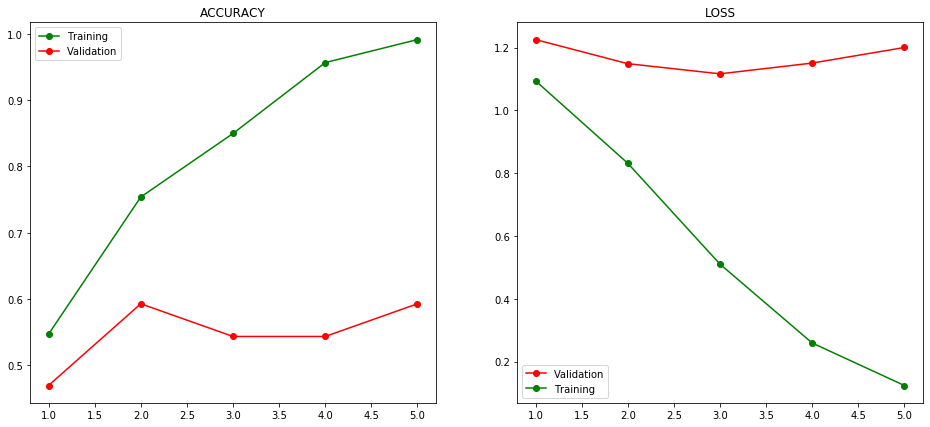

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      1.00       280
         NEU       1.00      0.95      0.98        84
        NONE       0.98      0.99      0.99       148
           P       1.00      1.00      1.00       207

   micro avg       0.99      0.99      0.99       719
   macro avg       0.99      0.99      0.99       719
weighted avg       0.99      0.99      0.99       719



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,1,80,3,0
NONE,0,0,147,1
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.71      0.77      0.74        31
         NEU       0.00      0.00      0.00        10
        NONE       0.43      0.35      0.39        17
           P       0.56      0.78      0.65        23

   micro avg       0.59      0.59      0.59        81
   macro avg       0.42      0.48      0.45        81
weighted avg       0.52      0.59      0.55        81



,N,NEU,NONE,P
Pred/True,,,,
N,24,1,4,2
NEU,3,0,2,5
NONE,4,0,6,7
P,3,0,2,18


### Fold number: 5. Name: 881f228527d9477faff40a129c254b1a

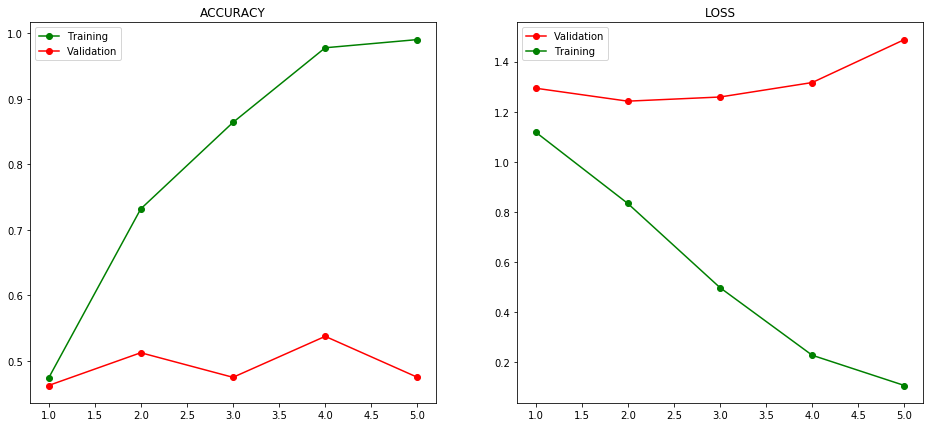

### Training

              precision    recall  f1-score   support

           N       0.98      1.00      0.99       280
         NEU       1.00      0.95      0.98        85
        NONE       0.99      0.99      0.99       148
           P       1.00      0.99      1.00       207

   micro avg       0.99      0.99      0.99       720
   macro avg       0.99      0.98      0.99       720
weighted avg       0.99      0.99      0.99       720



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,81,2,0
NONE,1,0,147,0
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.51      0.65      0.57        31
         NEU       0.00      0.00      0.00         9
        NONE       0.35      0.47      0.40        17
           P       0.59      0.43      0.50        23

   micro avg       0.47      0.47      0.48        80
   macro avg       0.36      0.39      0.37        80
weighted avg       0.44      0.47      0.45        80



,N,NEU,NONE,P
Pred/True,,,,
N,20,0,9,2
NEU,5,0,2,2
NONE,6,0,8,3
P,8,1,4,10


### Fold number: 6. Name: 3bc92ff01ba04bf4b7c420b246adcd31

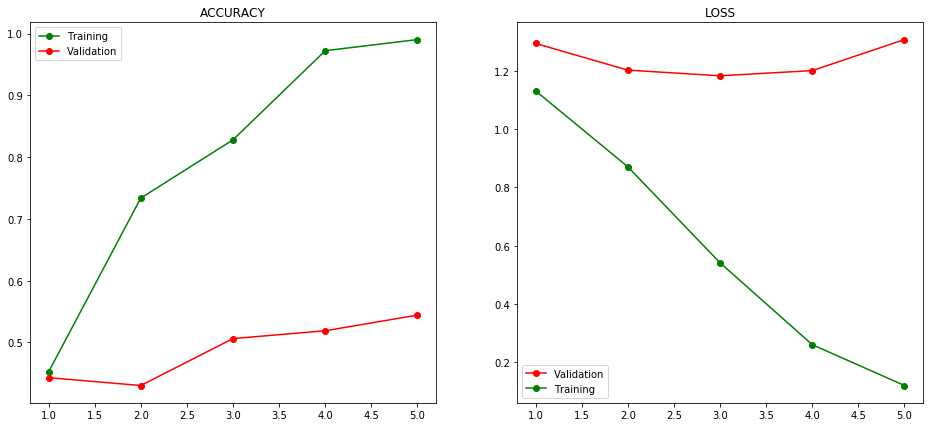

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.95      0.98        85
        NONE       0.99      1.00      1.00       149
           P       0.99      0.99      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.98      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,0,1
NEU,2,81,1,1
NONE,0,0,149,0
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.54      0.68      0.60        31
         NEU       0.00      0.00      0.00         9
        NONE       0.53      0.50      0.52        16
           P       0.56      0.61      0.58        23

   micro avg       0.54      0.54      0.54        79
   macro avg       0.41      0.45      0.42        79
weighted avg       0.48      0.54      0.51        79



,N,NEU,NONE,P
Pred/True,,,,
N,21,0,4,6
NEU,6,0,0,3
NONE,6,0,8,2
P,6,0,3,14


### Fold number: 7. Name: 67b814c97fdf47c4a8c4518a85ccf447

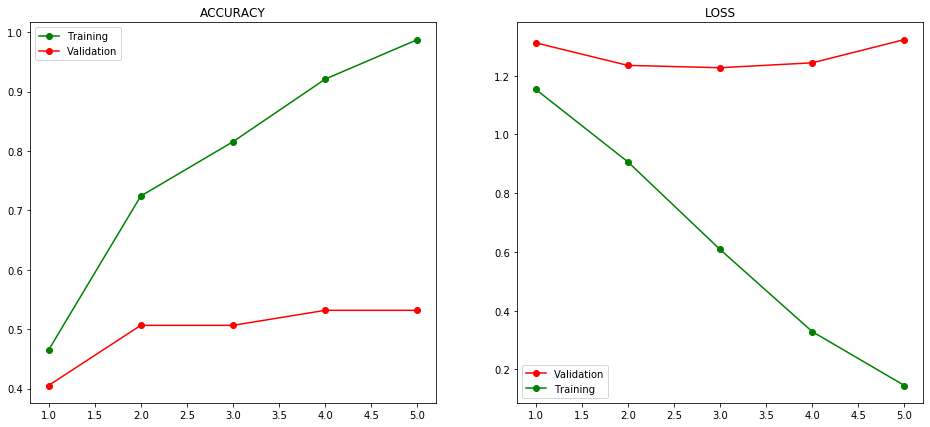

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.93      0.96        85
        NONE       0.99      0.99      0.99       149
           P       0.99      0.99      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.98      0.98       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,79,2,2
NONE,0,0,148,1
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.58      0.68      0.63        31
         NEU       0.00      0.00      0.00         9
        NONE       0.31      0.31      0.31        16
           P       0.59      0.70      0.64        23

   micro avg       0.53      0.53      0.53        79
   macro avg       0.37      0.42      0.39        79
weighted avg       0.46      0.53      0.50        79



,N,NEU,NONE,P
Pred/True,,,,
N,21,0,5,5
NEU,3,0,4,2
NONE,7,0,5,4
P,5,0,2,16


### Fold number: 8. Name: 2592d966eebd44ed92ebd18f2c6e070c

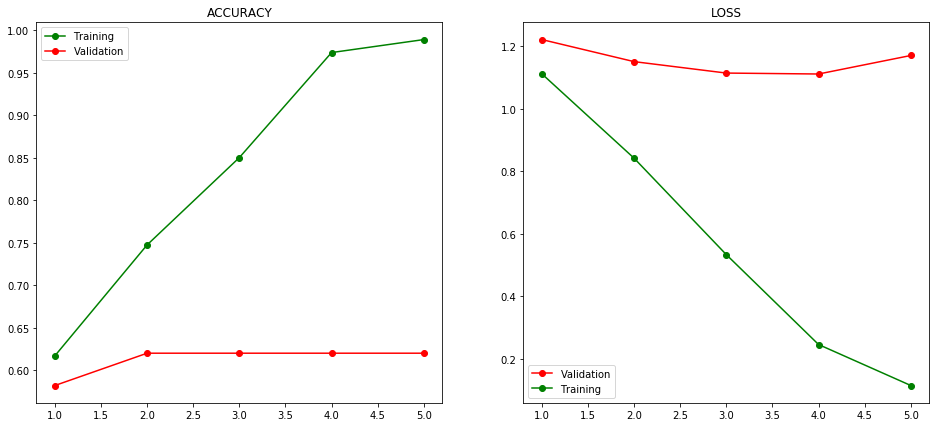

### Training

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       280
         NEU       1.00      0.95      0.98        85
        NONE       0.98      0.99      0.99       149
           P       1.00      0.99      0.99       207

   micro avg       0.99      0.99      0.99       721
   macro avg       0.99      0.98      0.99       721
weighted avg       0.99      0.99      0.99       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,2,81,2,0
NONE,0,0,148,1
P,2,0,1,204


### Validation

              precision    recall  f1-score   support

           N       0.64      0.87      0.74        31
         NEU       0.00      0.00      0.00         9
        NONE       0.45      0.62      0.53        16
           P       0.80      0.52      0.63        23

   micro avg       0.62      0.62      0.62        79
   macro avg       0.47      0.50      0.47        79
weighted avg       0.58      0.62      0.58        79



,N,NEU,NONE,P
Pred/True,,,,
N,27,0,4,0
NEU,5,0,2,2
NONE,5,0,10,1
P,5,0,6,12


### Fold number: 9. Name: cb91f15957df47cf85aaabdbe74d1169

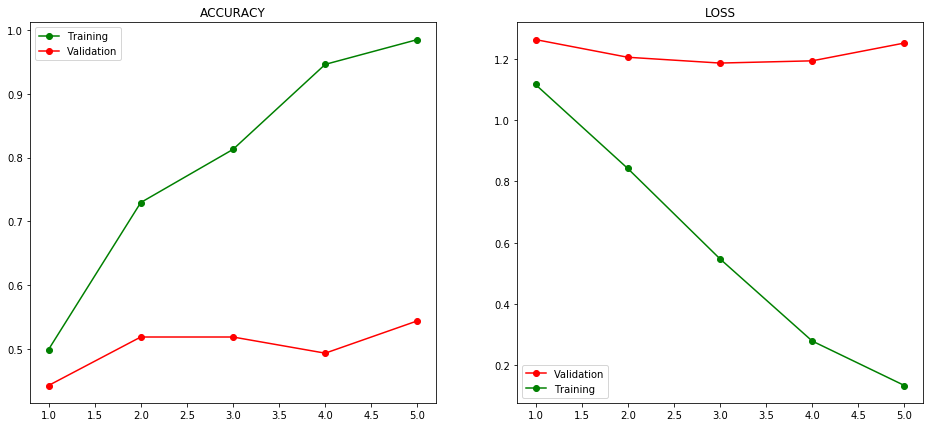

### Training

              precision    recall  f1-score   support

           N       0.99      0.99      0.99       280
         NEU       1.00      0.93      0.96        85
        NONE       0.99      0.99      0.99       149
           P       0.97      0.99      0.98       207

   micro avg       0.98      0.98      0.98       721
   macro avg       0.99      0.98      0.98       721
weighted avg       0.98      0.98      0.98       721



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,0,2
NEU,2,79,1,3
NONE,0,0,148,1
P,2,0,0,205


### Validation

              precision    recall  f1-score   support

           N       0.61      0.71      0.66        31
         NEU       0.00      0.00      0.00         9
        NONE       0.44      0.44      0.44        16
           P       0.54      0.61      0.57        23

   micro avg       0.54      0.54      0.54        79
   macro avg       0.40      0.44      0.42        79
weighted avg       0.49      0.54      0.51        79



,N,NEU,NONE,P
Pred/True,,,,
N,22,0,3,6
NEU,4,0,2,3
NONE,6,0,7,3
P,4,1,4,14


### Fold number: 10. Name: eebfb82f2d9842879eba0ab7c1b5f445

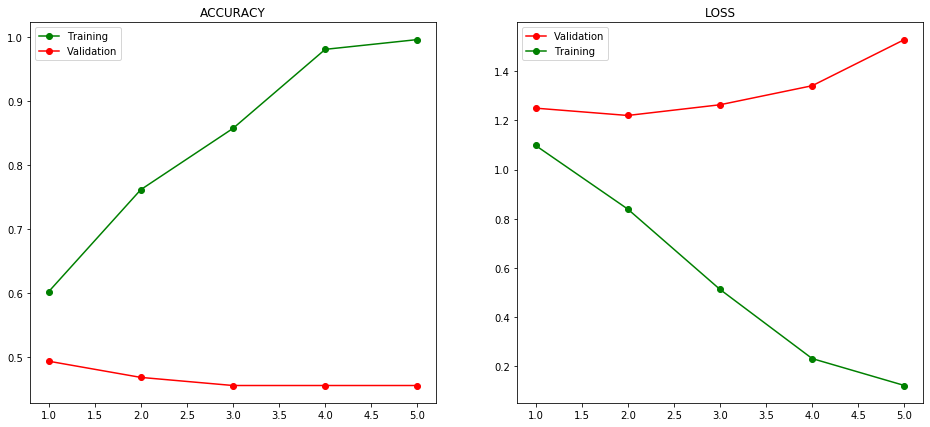

### Training

              precision    recall  f1-score   support

           N       1.00      1.00      1.00       280
         NEU       1.00      0.98      0.99        85
        NONE       0.99      1.00      0.99       149
           P       1.00      1.00      1.00       207

   micro avg       1.00      1.00      1.00       721
   macro avg       1.00      0.99      0.99       721
weighted avg       1.00      1.00      1.00       721



,N,NEU,NONE,P
Pred/True,,,,
N,280,0,0,0
NEU,0,83,2,0
NONE,0,0,149,0
P,1,0,0,206


### Validation

              precision    recall  f1-score   support

           N       0.57      0.52      0.54        31
         NEU       0.00      0.00      0.00         9
        NONE       0.29      0.50      0.36        16
           P       0.52      0.52      0.52        23

   micro avg       0.46      0.46      0.46        79
   macro avg       0.34      0.38      0.36        79
weighted avg       0.43      0.46      0.44        79



,N,NEU,NONE,P
Pred/True,,,,
N,16,0,8,7
NEU,3,0,4,2
NONE,6,0,8,2
P,3,0,8,12


## 5. SBW-vectors-300-min5.bin

### Fold number: 1. Name: c091629b547640828d350a4333def574

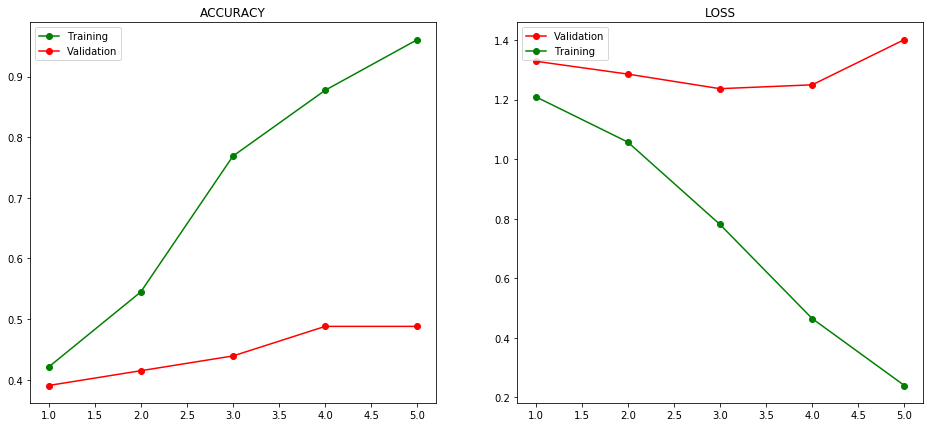

### Training

              precision    recall  f1-score   support

           N       0.95      1.00      0.97       279
         NEU       1.00      0.90      0.95        84
        NONE       0.97      0.93      0.95       148
           P       0.96      0.96      0.96       207

   micro avg       0.96      0.96      0.96       718
   macro avg       0.97      0.95      0.96       718
weighted avg       0.96      0.96      0.96       718



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,0,1
NEU,3,76,2,3
NONE,7,0,137,4
P,6,0,2,199


### Validation

              precision    recall  f1-score   support

           N       0.45      0.75      0.56        32
         NEU       1.00      0.10      0.18        10
        NONE       0.42      0.29      0.34        17
           P       0.62      0.43      0.51        23

   micro avg       0.49      0.49      0.49        82
   macro avg       0.62      0.39      0.40        82
weighted avg       0.56      0.49      0.46        82



,N,NEU,NONE,P
Pred/True,,,,
N,24,0,4,4
NEU,8,1,1,0
NONE,10,0,5,2
P,11,0,2,10


### Fold number: 2. Name: a2a8fb29090c4dfdbba078132c79de79

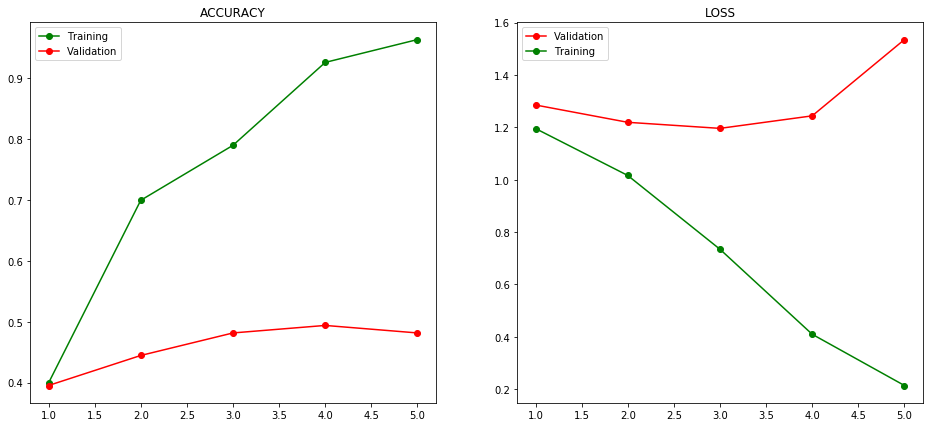

### Training

              precision    recall  f1-score   support

           N       0.94      0.99      0.96       280
         NEU       1.00      0.93      0.96        84
        NONE       0.96      0.93      0.94       148
           P       0.99      0.97      0.98       207

   micro avg       0.96      0.96      0.96       719
   macro avg       0.97      0.95      0.96       719
weighted avg       0.96      0.96      0.96       719



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,3,78,3,0
NONE,10,0,137,1
P,6,0,1,200


### Validation

              precision    recall  f1-score   support

           N       0.44      0.84      0.58        31
         NEU       0.00      0.00      0.00        10
        NONE       0.53      0.53      0.53        17
           P       0.80      0.17      0.29        23

   micro avg       0.48      0.48      0.48        81
   macro avg       0.44      0.39      0.35        81
weighted avg       0.51      0.48      0.41        81



,N,NEU,NONE,P
Pred/True,,,,
N,26,0,4,1
NEU,9,0,1,0
NONE,8,0,9,0
P,16,0,3,4


### Fold number: 3. Name: 7e2a2b15dd924409ba11275d2d03b577

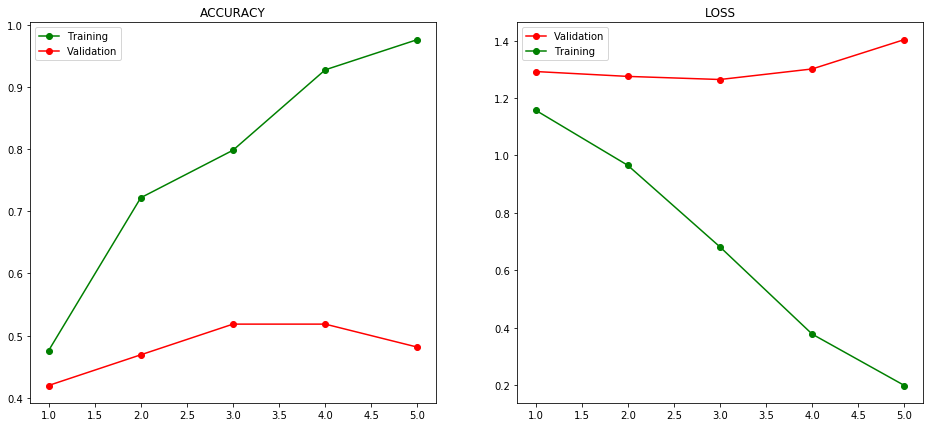

### Training

              precision    recall  f1-score   support

           N       0.98      0.99      0.99       280
         NEU       1.00      0.92      0.96        84
        NONE       0.97      0.99      0.98       148
           P       0.97      0.98      0.97       207

   micro avg       0.98      0.98      0.98       719
   macro avg       0.98      0.97      0.97       719
weighted avg       0.98      0.98      0.98       719



,N,NEU,NONE,P
Pred/True,,,,
N,277,0,2,1
NEU,1,77,1,5
NONE,1,0,146,1
P,3,0,2,202


### Validation

              precision    recall  f1-score   support

           N       0.60      0.48      0.54        31
         NEU       0.00      0.00      0.00        10
        NONE       0.37      0.65      0.47        17
           P       0.50      0.57      0.53        23

   micro avg       0.48      0.48      0.48        81
   macro avg       0.37      0.42      0.38        81
weighted avg       0.45      0.48      0.45        81



,N,NEU,NONE,P
Pred/True,,,,
N,15,0,10,6
NEU,4,0,2,4
NONE,3,0,11,3
P,3,0,7,13


### Fold number: 4. Name: bec6e63d8d32438494bcd921090df352

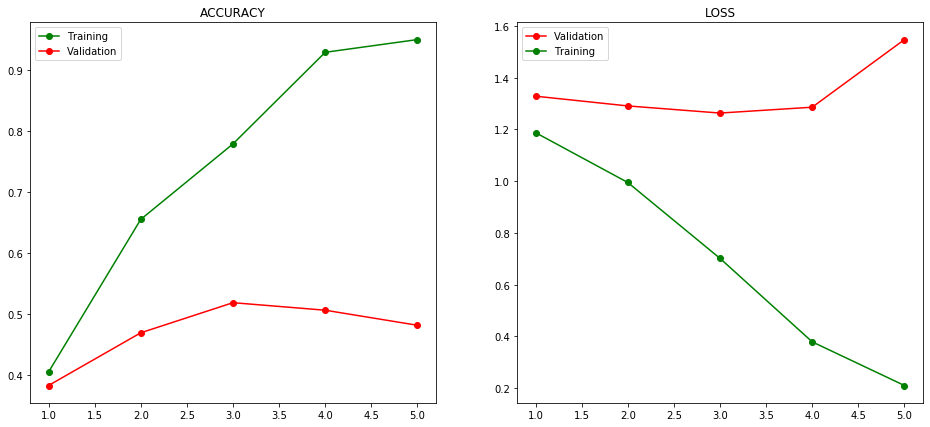

### Training

              precision    recall  f1-score   support

           N       0.90      0.99      0.94       280
         NEU       1.00      0.82      0.90        84
        NONE       0.99      0.92      0.95       148
           P       0.99      0.97      0.98       207

   micro avg       0.95      0.95      0.95       719
   macro avg       0.97      0.92      0.94       719
weighted avg       0.95      0.95      0.95       719



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,15,69,0,0
NONE,10,0,136,2
P,6,0,1,200


### Validation

              precision    recall  f1-score   support

           N       0.47      0.90      0.62        31
         NEU       0.00      0.00      0.00        10
        NONE       0.33      0.06      0.10        17
           P       0.56      0.43      0.49        23

   micro avg       0.48      0.48      0.48        81
   macro avg       0.34      0.35      0.30        81
weighted avg       0.41      0.48      0.40        81



,N,NEU,NONE,P
Pred/True,,,,
N,28,0,1,2
NEU,6,0,1,3
NONE,13,0,1,3
P,13,0,0,10


### Fold number: 5. Name: 99f442991ca54eab9776b79c7b6d0506

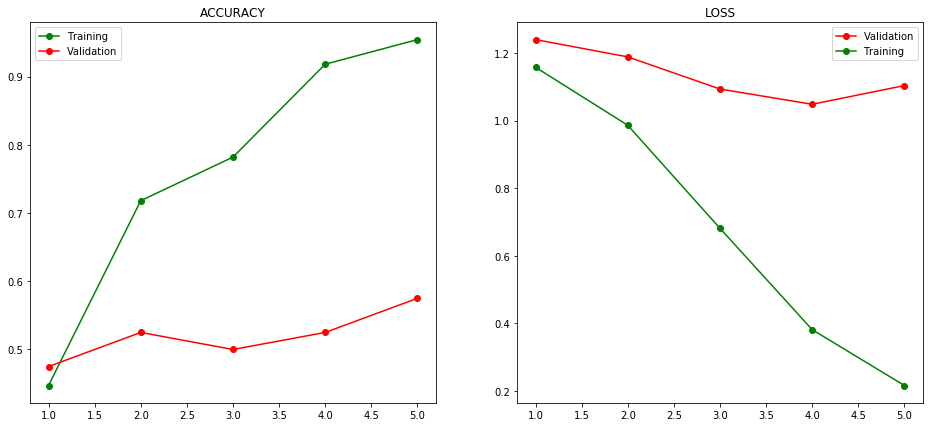

### Training

              precision    recall  f1-score   support

           N       0.91      0.99      0.95       280
         NEU       1.00      0.85      0.92        85
        NONE       0.98      0.93      0.95       148
           P       0.99      0.97      0.98       207

   micro avg       0.95      0.95      0.95       720
   macro avg       0.97      0.93      0.95       720
weighted avg       0.96      0.95      0.95       720



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,12,72,1,0
NONE,9,0,137,2
P,6,0,1,200


### Validation

              precision    recall  f1-score   support

           N       0.54      0.97      0.69        31
         NEU       0.00      0.00      0.00         9
        NONE       0.33      0.12      0.17        17
           P       0.78      0.61      0.68        23

   micro avg       0.57      0.57      0.57        80
   macro avg       0.41      0.42      0.39        80
weighted avg       0.50      0.57      0.50        80



,N,NEU,NONE,P
Pred/True,,,,
N,30,0,0,1
NEU,7,0,1,1
NONE,13,0,2,2
P,6,0,3,14


### Fold number: 6. Name: 81e959bffd4242cea6caa8db9eed2369

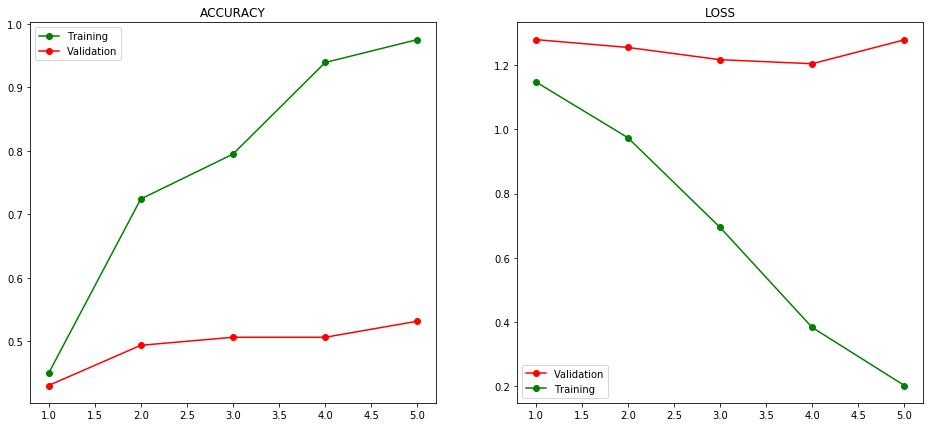

### Training

              precision    recall  f1-score   support

           N       0.96      0.99      0.97       280
         NEU       1.00      0.95      0.98        85
        NONE       0.99      0.95      0.97       149
           P       0.99      0.98      0.98       207

   micro avg       0.98      0.98      0.98       721
   macro avg       0.98      0.97      0.97       721
weighted avg       0.98      0.98      0.98       721



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,3,81,1,0
NONE,6,0,141,2
P,4,0,0,203


### Validation

              precision    recall  f1-score   support

           N       0.52      0.90      0.66        31
         NEU       0.00      0.00      0.00         9
        NONE       0.42      0.31      0.36        16
           P       0.69      0.39      0.50        23

   micro avg       0.53      0.53      0.53        79
   macro avg       0.41      0.40      0.38        79
weighted avg       0.49      0.53      0.48        79



,N,NEU,NONE,P
Pred/True,,,,
N,28,0,1,2
NEU,6,0,2,1
NONE,10,0,5,1
P,10,0,4,9


### Fold number: 7. Name: 5ec79683ae7f4f9fb4efe78856a08df6

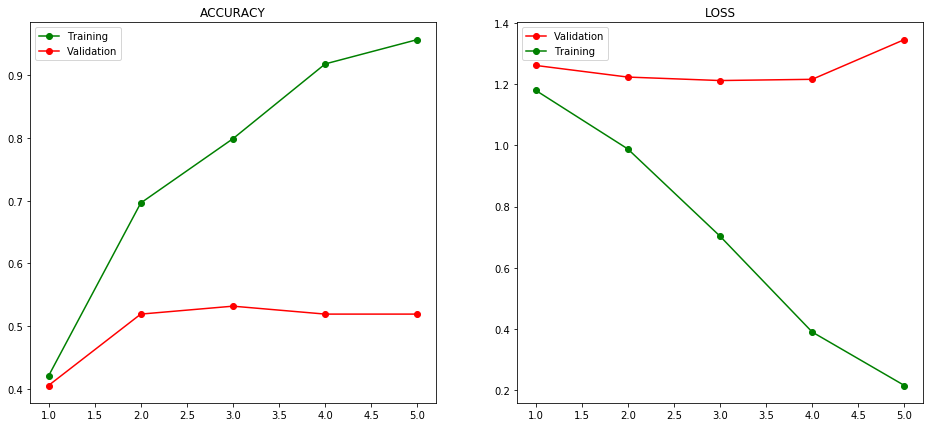

### Training

              precision    recall  f1-score   support

           N       0.93      0.99      0.96       280
         NEU       1.00      0.89      0.94        85
        NONE       0.96      0.91      0.94       149
           P       0.98      0.97      0.97       207

   micro avg       0.96      0.96      0.96       721
   macro avg       0.97      0.94      0.95       721
weighted avg       0.96      0.96      0.96       721



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,6,76,3,0
NONE,10,0,136,3
P,6,0,1,200


### Validation

              precision    recall  f1-score   support

           N       0.51      0.84      0.63        31
         NEU       0.00      0.00      0.00         9
        NONE       0.50      0.25      0.33        16
           P       0.55      0.48      0.51        23

   micro avg       0.52      0.52      0.52        79
   macro avg       0.39      0.39      0.37        79
weighted avg       0.46      0.52      0.47        79



,N,NEU,NONE,P
Pred/True,,,,
N,26,0,2,3
NEU,6,0,1,2
NONE,8,0,4,4
P,11,0,1,11


### Fold number: 8. Name: 3e6e478a988649948a2754ae70701d3d

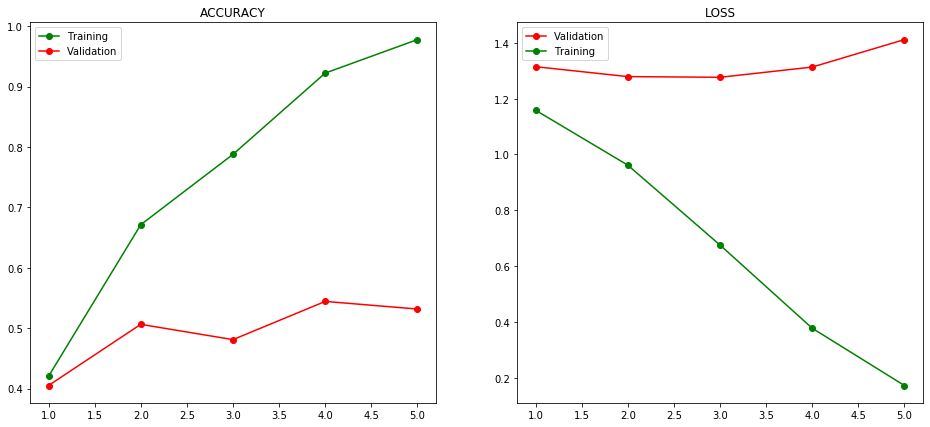

### Training

              precision    recall  f1-score   support

           N       0.97      0.99      0.98       280
         NEU       1.00      0.95      0.98        85
        NONE       0.97      0.97      0.97       149
           P       0.99      0.98      0.98       207

   micro avg       0.98      0.98      0.98       721
   macro avg       0.98      0.97      0.98       721
weighted avg       0.98      0.98      0.98       721



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,2,81,2,0
NONE,4,0,144,1
P,3,0,2,202


### Validation

              precision    recall  f1-score   support

           N       0.54      0.81      0.65        31
         NEU       0.00      0.00      0.00         9
        NONE       0.33      0.12      0.18        16
           P       0.62      0.65      0.64        23

   micro avg       0.53      0.53      0.53        79
   macro avg       0.38      0.40      0.37        79
weighted avg       0.46      0.53      0.48        79



,N,NEU,NONE,P
Pred/True,,,,
N,25,1,3,2
NEU,8,0,0,1
NONE,8,0,2,6
P,5,2,1,15


### Fold number: 9. Name: e81aef8522454ac8a35c6cfff111ca89

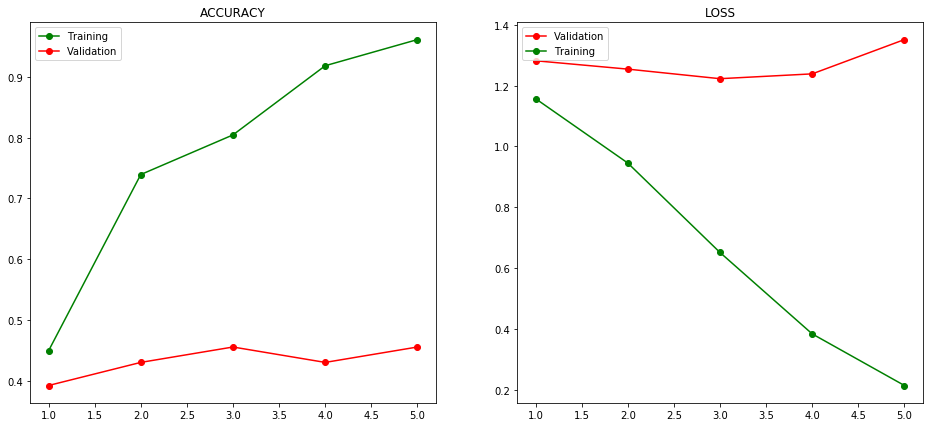

### Training

              precision    recall  f1-score   support

           N       0.93      0.99      0.96       280
         NEU       1.00      0.88      0.94        85
        NONE       0.97      0.94      0.95       149
           P       0.99      0.97      0.98       207

   micro avg       0.96      0.96      0.96       721
   macro avg       0.97      0.95      0.96       721
weighted avg       0.96      0.96      0.96       721



,N,NEU,NONE,P
Pred/True,,,,
N,278,0,1,1
NEU,8,75,2,0
NONE,7,0,140,2
P,5,0,2,200


### Validation

              precision    recall  f1-score   support

           N       0.44      0.71      0.54        31
         NEU       0.00      0.00      0.00         9
        NONE       0.25      0.12      0.17        16
           P       0.60      0.52      0.56        23

   micro avg       0.46      0.46      0.46        79
   macro avg       0.32      0.34      0.32        79
weighted avg       0.40      0.46      0.41        79



,N,NEU,NONE,P
Pred/True,,,,
N,22,0,4,5
NEU,7,0,1,1
NONE,12,0,2,2
P,9,1,1,12


### Fold number: 10. Name: 5732297bf2244c3cba3c28bcd413505b

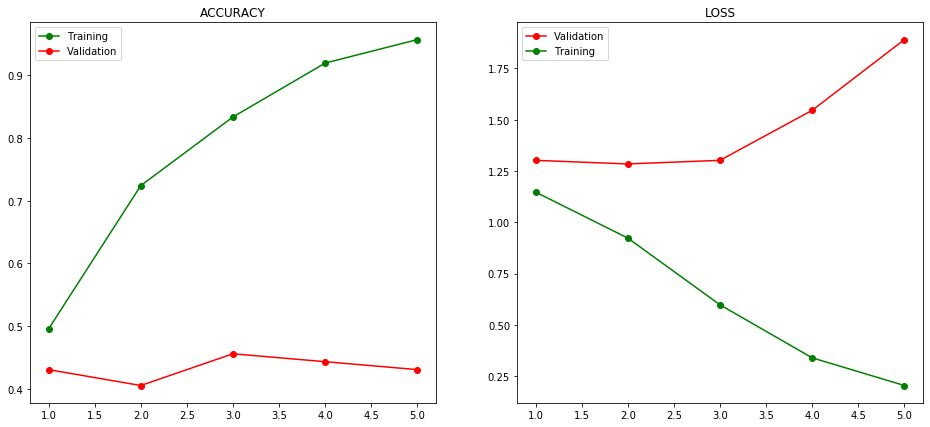

### Training

              precision    recall  f1-score   support

           N       0.92      1.00      0.96       280
         NEU       1.00      0.87      0.93        85
        NONE       0.97      0.92      0.94       149
           P       0.99      0.97      0.98       207

   micro avg       0.96      0.96      0.96       721
   macro avg       0.97      0.94      0.95       721
weighted avg       0.96      0.96      0.96       721



,N,NEU,NONE,P
Pred/True,,,,
N,279,0,1,0
NEU,10,74,1,0
NONE,10,0,137,2
P,5,0,2,200


### Validation

              precision    recall  f1-score   support

           N       0.42      0.94      0.58        31
         NEU       0.00      0.00      0.00         9
        NONE       0.33      0.06      0.11        16
           P       0.57      0.17      0.27        23

   micro avg       0.43      0.43      0.43        79
   macro avg       0.33      0.29      0.24        79
weighted avg       0.40      0.43      0.33        79



,N,NEU,NONE,P
Pred/True,,,,
N,29,0,0,2
NEU,8,0,0,1
NONE,15,0,1,0
P,17,0,2,4


In [7]:
#%matplotlib notebook
display(Markdown(f'# Convolutional Neural Network'))
word_vectors = wv_rep.get_all()
word_vector_names = []
lab_reports = []
#word_vectors = [word_vectors.__next__()] #comment!!!!!
for i, word_vector in enumerate(word_vectors):
    wv_service = WordVectorsService(word_vector)
    input = ClassifierInput(comments, wv_service)
    lab = CnnLab( model_dao)
    lab_report = classification_lab_report(i+1, input, lab)
    model_architecture_summary(lab_report)
    word_vector_names.append(word_vector.name)
    lab_reports.append(lab_report)
    
for i, word_vector_name in enumerate(word_vector_names): 
    lab_report = lab_reports[i]
    show_statistics_by_model(i+1, word_vector_name, lab_report)
    